# Imports + Fonctions

In [51]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import psycopg2
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from typing import List, Optional, Dict, Any
from collections import defaultdict
from xgboost import XGBClassifier

In [52]:
load_dotenv()
database_url = os.getenv("DATABASE_URL")
user = os.getenv("USER")
password = os.getenv("PASSWORD")

In [53]:
suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
def convert_bytes(nbytes):
    i=0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes/=1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i]) 

In [54]:
def data_processing(query):
    engine = create_engine(database_url)
    conn = engine.connect().execution_options(stream_results=True)

    chunks = []
    total_mem = 0
    i = 1

    for chunk_df in pd.read_sql_query(query, conn, chunksize=500000):
        print(f"Chunk {i} - rows: {len(chunk_df)}")
        total_mem += chunk_df.memory_usage(index=True, deep=True).sum()
        print(f" Memory usage: {chunk_df.memory_usage(deep=True).sum()/1024}")
        print(f"sys.getsizeof {sys.getsizeof(chunk_df)/1024}" )
        print(f" sys.getsizeof : {convert_bytes(chunk_df.memory_usage(index=True, deep=True).sum())}")
        chunks.append(chunk_df)
        i+=1

    df = pd.concat(chunks, ignore_index=True)
    print(f"\n✅ Données chargées : {df.shape}")
    print(f"📊 Mémoire totale estimée : {convert_bytes(total_mem)}")

    return df


def show_most_na_col(df):
    missing_percent = df.isnull().mean().sort_values(ascending=False) * 100

    missing_df = missing_percent.reset_index()
    missing_df.columns = ['column_name', 'missing_percentage']

    #Filtrer les 20 premières colonnes avec le plus de Nan

    top_missing = missing_df.head(20)

    #Affichage avec seaborn
    plt.figure(figsize=(12,6))
    sns.barplot(x="missing_percentage", y="column_name", data= top_missing, palette="viridis")

    plt.title("Top 20 colonnes avec le plus de valeurs manquantes")
    plt.xlabel("Pourcentage de valeurs manquantes(%)")
    plt.ylabel("Colonnes")
    plt.tight_layout()
    plt.show
def show_least_na_col(df):
    
    missing_percent = df.isnull().mean().sort_values(ascending=False) * 100

    missing_df = missing_percent.reset_index()
    missing_df.columns = ['column_name', 'missing_percentage']
    least_missing = missing_df.tail(20)

    #Affichage avec seaborn
    plt.figure(figsize=(12,6))
    sns.barplot(x="missing_percentage", y="column_name", data= least_missing, palette="viridis")

    plt.title("Top 20 colonnes avec le moins de valeurs manquantes")
    plt.xlabel("Pourcentage de valeurs manquantes(%)")
    plt.ylabel("Colonnes")
    plt.tight_layout()
    plt.show

def show_all_col_na(df):
    missing_percent = df.isnull().mean().sort_values(ascending=False) * 100

    missing_df = missing_percent.reset_index()
    missing_df.columns = ['column_name', 'missing_percentage']
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    labels = [f"{i}–{i+10}%" for i in bins[:-1]]
    missing_bins = pd.cut(missing_percent, bins=bins, labels=labels, include_lowest=True)

    # Compte le nombre de colonnes dans chaque tranche
    bin_counts = missing_bins.value_counts().sort_index()

    # Affiche le histogramme
    plt.figure(figsize=(10, 6))
    sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="viridis")
    plt.title("Nombre de colonnes par tranche de pourcentage de valeurs manquantes")
    plt.xlabel("Tranche de pourcentage de valeurs manquantes")
    plt.ylabel("Nombre de colonnes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [55]:
def cross_train_report_rf(df: pd.DataFrame, cv: bool, feature_list_number: Optional[List[int]] = None, feature_number: Optional[int] = None, user_input: Optional[Dict[str, Any]] = None):
    # 1. Identifier la cible et les features
    target_col = 'etiquette_dpe'  # Remplace par le nom de ta variable cible
    if user_input is None:
        X = df.drop(columns=[target_col])
    elif user_input is not None:
        X = df[list(user_input.keys())]
    y = df[target_col]

    # 2. Séparer qualitatives et quantitatives
    qualitative_cols = X.select_dtypes(include=['object', 'category']).columns
    quantitative_cols = X.select_dtypes(include=['number']).columns

    # 3. Encoder les variables qualitatives (one-hot)
    X_encoded = pd.get_dummies(X, columns=qualitative_cols, drop_first=True)

    print(X_encoded.shape)

    # 4. Split
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    # 5. RandomForest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    if feature_list_number is None and feature_number is None:
        if cv:
            # 5 bis. Cross-validation
            cv_scores = cross_val_score(rf, X_encoded, y, cv=5)
            print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
        
        # Prédictions
        y_pred = rf.predict(X_test)

        # Accuracy
        acc = accuracy_score(y_test, y_pred)
        print(f"\nTest Accuracy : {acc:.2f}")

        # Rapport complet (précision, rappel, f1-score)
        print("\nClassification Report :\n", classification_report(y_test, y_pred))

        # Matrice de confusion
        plt.figure(figsize=(6, 5))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title("Matrice de confusion")
        plt.xlabel("Prédit")
        plt.ylabel("Réel")
        plt.tight_layout()
        plt.show()

        # 6. Importance des features
        importances = rf.feature_importances_
        features = X_encoded.columns

        # 7. Affichage
        feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x=feature_importance[:30], y=feature_importance.index[:30])  # top 30 features
        plt.title("Top 30 Features les plus importantes - Random Forest")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()  

        ### On essaies de regrouper l'importance des variables quali entres elle pour voir
        grouped_importance = defaultdict(float)

        for col, importance in zip(X_encoded.columns, importances):
            base_var = col.rsplit("_",1)[0]  # ex: 'region_Occitanie' -> 'region'
            grouped_importance[base_var] += importance

        grouped_importance_series = pd.Series(grouped_importance).sort_values(ascending=False)

        # 7 bis. Affichage des importances groupées
        plt.figure(figsize=(12, 8))
        sns.barplot(x=grouped_importance_series[:30], y=grouped_importance_series.index[:30])
        plt.title("Top 30 variables d'origine les plus importantes (importances groupées)")
        plt.xlabel("Importance cumulée")
        plt.tight_layout()
        plt.show()
    elif feature_list_number is not None and feature_number is None:
        importances = rf.feature_importances_
        features = X_encoded.columns
        feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)
        accuracies = []

        for n in feature_list_number:
            top_features = feature_importance[:n].index.tolist()
            X_top = X_encoded[top_features]
            
            X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y, test_size=0.2, random_state=42)

            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X_train_top, y_train_top)
            
            y_pred_top = rf.predict(X_test_top)
            acc = accuracy_score(y_test_top, y_pred_top)
            accuracies.append(acc)
            print(f"Top {n} features → Accuracy: {acc:.4f}")

        # 3. Visualisation
        plt.figure(figsize=(8, 5))
        plt.plot(feature_list_number, accuracies, marker='o')
        plt.xlabel("Nombre de variables utilisées")
        plt.ylabel("Accuracy")
        plt.title("Impact de la réduction de variables sur la performance")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    elif feature_number is not None and feature_list_number is None:
        importances = rf.feature_importances_
        features = X_encoded.columns
        feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)
        # top_features_n = feature_importance[:feature_number].index.tolist()
        top_features_n = feature_importance[feature_number:].index.tolist()
        display(top_features_n)
        X_top_n = X_encoded[top_features_n]

        # 3. Split train/test
        X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_top_n, y, test_size=0.2, random_state=42)

        # 4. Cross-validation (ex: 5-folds)
        rf_n = RandomForestClassifier(n_estimators=100, random_state=42)
        cv_scores = cross_val_score(rf_n, X_train_n, y_train_n, cv=5, scoring='accuracy')
        print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

        # 5. Train sur tout le X_train_N pour afficher la matrice de confusion
        rf_n.fit(X_train_n, y_train_n)
        y_pred_n = rf_n.predict(X_test_n)

        # Rapport complet (précision, rappel, f1-score)
        print("\nClassification Report :\n", classification_report(y_test_n, y_pred_n))


        # 6. Matrice de confusion
        plt.figure(figsize=(6, 5))
        sns.heatmap(confusion_matrix(y_test_n, y_pred_n), annot=True, fmt='d', cmap='Blues')
        plt.title("Matrice de confusion - Top 10 features")
        plt.xlabel("Prédit")
        plt.ylabel("Réel")
        plt.tight_layout()
        plt.show()
    else: 
        raise ValueError("Tu ne peux pas fournir à la fois feature_number et feature_list_number.")


In [56]:
def train_predict_from_user_input(df: pd.DataFrame, user_input: Optional[Dict[str, Any]] = None):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import seaborn as sns

    target_col = 'etiquette_dpe'

    # 1. On enlève la target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # 2. On restreint aux colonnes renseignées par l'utilisateur
    used_features = list(user_input.keys())
    X = X[used_features]

    # 3. Encodage du X complet (train)
    qualitative_cols = X.select_dtypes(include=['object', 'category']).columns
    X_encoded = pd.get_dummies(X, columns=qualitative_cols, drop_first=True)

    # 4. Split
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    # 5. Entraînement du modèle
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # 6. Score de test
    acc = rf.score(X_test, y_test)
    print(f"✅ Test Accuracy: {acc:.2f}")

    # 7. Encodage des données utilisateur
    user_df = pd.DataFrame([user_input])
    user_encoded = pd.get_dummies(user_df)

    # 🔥 ALIGNEMENT ici — c’est crucial
    user_encoded = user_encoded.reindex(columns=X_encoded.columns, fill_value=0)

    # 8. Prédiction
    prediction = rf.predict(user_encoded)[0]
    print(f"🔮 Prédiction sur données utilisateur : {prediction}")

    # 9. Affichage des 20 variables les plus importantes
    importances = rf.feature_importances_
    feature_names = X_encoded.columns
    feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20])
    plt.title("Top 20 Features Importantes")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    return prediction, acc


In [ ]:
from sklearn.preprocessing import LabelEncoder

def train_predict_from_user_input_xgboost(df: pd.DataFrame, user_input: Optional[Dict[str, Any]] = None):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    from xgboost import XGBClassifier
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (
        accuracy_score,
        confusion_matrix,
        ConfusionMatrixDisplay,
        classification_report
    )
    import pandas as pd

    target_col = 'etiquette_dpe'

    # 1. Séparer X et y
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # 🔤 Encodage de y
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)  # 'A' -> 0, ..., 'G' -> 6

    # 2. Utiliser uniquement les colonnes fournies par l'utilisateur
    used_features = list(user_input.keys())
    X = X[used_features]

    # 3. Encodage de X (variables catégorielles)
    qualitative_cols = X.select_dtypes(include=['object', 'category']).columns
    X_encoded = pd.get_dummies(X, columns=qualitative_cols, drop_first=True)
    X_encoded.columns = X_encoded.columns.str.replace(r"[<>[\]()]","_", regex=True)
    # 4. Split
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

    # 5. Entraînement du modèle
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb.fit(X_train, y_train)

    # 6. Score
    acc = xgb.score(X_test, y_test)
    





    # 9. Features importantes
    importances = xgb.feature_importances_
    feature_names = X_encoded.columns
    feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    # 🌍 Mapping pour affichage compréhensible (facultatif mais utile)
    feature_mapping = {
        'conso_5_usages_par_m2_ep': 'total_energy_ep',
        'conso_5 usages_par_m2_ef': 'total_energy_ef',
        'emission_ges_5_usages par_m2': 'total_ghg_emissions',
        'description_installation_ecs_n1_Chauffe-eau thermodynamique sur air extrait installé à partir de 2015, couplé avec un système solaire': 'solar_heatpump_2015',
        'cout_chauffage': 'heating_cost'
    }

    # Remplacer les noms connus par leur version lisible
    feature_importance_display = feature_importance.copy()
    feature_importance_display.index = [
        feature_mapping.get(feat, feat) for feat in feature_importance.index
    ]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance_display[:5], y=feature_importance_display.index[:5])
    plt.title("Top 5 Important Features (XGBoost)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

        # Prédictions sur le test set
    y_pred_test = xgb.predict(X_test)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

    # Affichage
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix (XGBoost)")
    plt.grid(False)
    plt.show()


    print(f"✅ Test Accuracy (XGBoost): {acc:.2f}")
    
    # 9. Rapport complet
    print("📊 Classification report:")
    print(classification_report(y_test, y_pred_test, target_names=le.classes_))

    

    # 🔁 10. "Précision tolérante" ±1 classe
    within_1_class = (abs(y_pred_test - y_test) <= 1).sum()
    total = len(y_test)
    percent_within_1 = 100 * within_1_class / total
    print(f"🎯 Accuracy ±1 class (tolerance) : {percent_within_1:.2f}%")

    
    # 11. Prediction sur input utilisateur
    user_df = pd.DataFrame([user_input])
    user_encoded = pd.get_dummies(user_df)
    user_encoded.columns = user_encoded.columns.str.replace(r"[<>[\]()]","_", regex=True)
    user_encoded = user_encoded.reindex(columns=X_encoded.columns, fill_value=0)
    pred = xgb.predict(user_encoded)[0]
    pred_label = le.inverse_transform([pred])[0]
    print(f"🔮 Prediction on user data : {pred_label}")

    return pred_label, acc


In [58]:
scenarios = [
    {
        "name": "Modèle existant - conso réelles",
        "variables": [
            'conso_5_usages_par_m2_ep',
            'emission_ges_5_usages par_m2',
            'conso_5 usages_par_m2_ef',
            'cout_chauffage',
            'emission_ges_chauffage_energie_n1',
            'cout_total_5_usages_energie_n1',
            'conso_chauffage_ef_energie_n1',
            'conso_chauffage_generateur_n1_installation_n1',
            'ubat_w_par_m2_k'
        ],
        "type": "réel"
    },
    {
        "name": "Modèle simulation - infos physiques",
        "variables": [
            'ubat_w_par_m2_k',
            'conso_chauffage_generateur_n1_installation_n1',
            'conso_chauffage_ef_energie_n1'
        ],
        "type": "simulation"
    }
]


In [59]:
def evaluate_rf_scenario(
    df: pd.DataFrame,
    scenario_name: str, 
    variables: List[str],
    type_modele: str,
    benchmark_results: List[Dict],
    cv: bool = False,
    verbose: bool = True
    ):
    target_col = 'etiquette_dpe'
    X = df[variables]
    y = df[target_col]

    # Encoder les variables catégorielles
    qualitative_cols = X.select_dtypes(include=['object', 'category']).columns
    X_encoded = pd.get_dummies(X, columns=qualitative_cols, drop_first=True)

    # Vérifier si le scénario existe déjà dans le benchmark
    existing = any(entry["Nom du modèle"] == scenario_name for entry in benchmark_results)
    if existing:
        if verbose:
            print(f"⚠️  Le scénario '{scenario_name}' existe déjà dans le benchmark. Ignoré.")
        return benchmark_results

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    # Modèle
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Cross-validation si demandé
    if cv:
        cv_scores = cross_val_score(rf, X_encoded, y, cv=5)
        acc_cv = cv_scores.mean()
        std_cv = cv_scores.std()
        if verbose:
            print(f"Cross-Validation Accuracy: {acc_cv:.2f} ± {std_cv:.2f}")
    else:
        acc_cv = None

    # Prédictions
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # Ajout au benchmark
    benchmark_results.append({
        "Nom du modèle": scenario_name,
        "Variables utilisées": variables,
        "Type": type_modele,
        "Modèle ML": "RandomForest",
        "Accuracy": round(acc, 4),
        "CV Mean": round(acc_cv, 4) if acc_cv is not None else None
    })

    # Affichage des résultats
    if verbose:
        print(f"\n✅ Test Accuracy pour '{scenario_name}' : {acc:.4f}")
        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        
        # Matrice de confusion
        plt.figure(figsize=(6, 5))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f"Matrice de confusion - {scenario_name}")
        plt.xlabel("Prédit")
        plt.ylabel("Réel")
        plt.tight_layout()
        plt.show()

        # Importances des features
        importances = rf.feature_importances_
        features = X_encoded.columns
        feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x=feature_importance[:30], y=feature_importance.index[:30])
        plt.title(f"Top 30 features - {scenario_name}")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

    return benchmark_results

# First analysis with NA on class_bilan_dpe (TABLE: batiment_groupe_dpe_representatif_logement)

In [22]:
query = """
        SELECT * 
        FROM dpe_equilibree 
        """

df = data_processing(query)

Chunk 1 - rows: 10500
 Memory usage: 65104.5
sys.getsizeof 65104.53125
 sys.getsizeof : 63.58 MB

✅ Données chargées : (10500, 224)
📊 Mémoire totale estimée : 63.58 MB


In [23]:
display(df.head())

,numero_dpe,date_derniere_modification_dpe,date_visite_diagnostiqueur,date_etablissement_dpe,date_reception_dpe,date_fin_validite_dpe,numero_dpe_remplace,numero_dpe_immeuble_associe,id_rnb,numero_rpls_logement,...,description_generateur_froid,surface_climatisee,conso_refroidissement_annuel,categorie_enr,systeme_production_electricite_origine_renouvelable,presence_production_pv,surface_totale_capteurs_pv,nombre_module,production_electricite_pv_kwhep_par_an,electricite_pv_autoconsommee
0,2220E2617014F,2024-06-26,2022-11-04,2022-11-04,2022-11-05,2032-11-03,None,None,None,NaN,...,Refroidissement - Electrique - Pompe à chaleur...,29.3,29.3,Il existe plusieurs descriptifs ENR,None,NaN,NaN,NaN,0.0,NaN
1,2230E1554722F,2024-12-30,2022-07-04,2022-07-04,2022-07-07,2032-07-03,None,None,PEG2MZCSF2Z1,NaN,...,Climatisation 1,104.0,356.7,Il existe plusieurs descriptifs ENR,None,NaN,NaN,NaN,0.0,NaN
2,2230E2257066L,2024-02-06,2022-09-27,2022-09-29,2022-09-30,2032-09-28,2230E2254831M,None,None,NaN,...,Refroidissement - Electrique - Pompe à chaleur...,95.3,527.7,Il existe plusieurs descriptifs ENR,None,NaN,NaN,NaN,0.0,NaN
3,2213E2921313T,2024-02-06,2022-10-13,2022-12-04,2022-12-05,2032-12-03,None,2213E2920791R,None,NaN,...,None,NaN,NaN,chauffe-eau thermodynamique,Solaire Photovoltaïque,0.0,NaN,NaN,0.0,NaN
4,2242E2193154T,2024-12-30,2022-09-19,2022-09-22,2022-09-23,2032-09-21,None,None,A1BTPQWZMQWN,NaN,...,None,NaN,NaN,pompe à chaleur,None,NaN,NaN,NaN,0.0,NaN


In [24]:
# Pourcentage de valeurs manquantes par colonne

missing_percent = df.isnull().mean().sort_values(ascending=False) * 100

# # Affichage
# missing_df = pd.DataFrame({
#     'colonne': missing_percent.index,
#     'pourcentage_nan': missing_percent.values
# })

# #Afficher les colonnes et leur valeurs manquantes
# missing_df.head(40)

C:\Users\Adnane.BEN-ALI\AppData\Local\Temp\ipykernel_4680\234471432.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="missing_percentage", y="column_name", data= top_missing, palette="viridis" )


<function matplotlib.pyplot.show(close=None, block=None)>

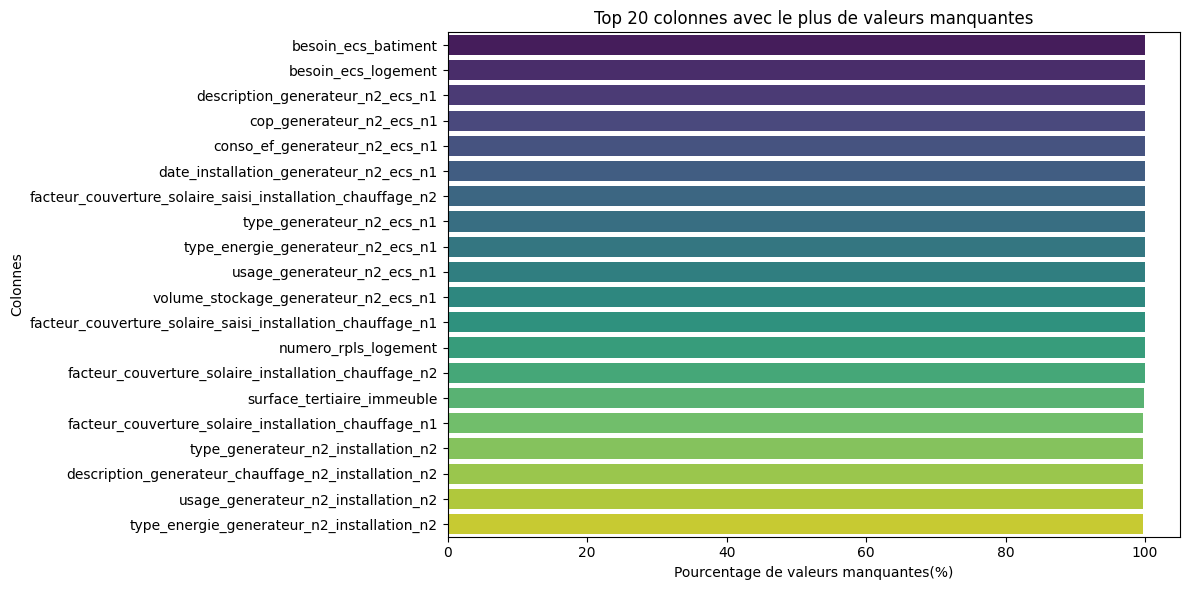

In [25]:
missing_df = missing_percent.reset_index()
missing_df.columns = ['column_name', 'missing_percentage']

#Filtrer les 20 premières colonnes avec le plus de Nan

top_missing = missing_df.head(20)

#Affichage avec seaborn
plt.figure(figsize=(12,6))
sns.barplot(x="missing_percentage", y="column_name", data= top_missing, palette="viridis" )

plt.title("Top 20 colonnes avec le plus de valeurs manquantes")
plt.xlabel("Pourcentage de valeurs manquantes(%)")
plt.ylabel("Colonnes")
plt.tight_layout()
plt.show

C:\Users\Adnane.BEN-ALI\AppData\Local\Temp\ipykernel_4680\3590135676.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="missing_percentage", y="column_name", data= least_missing, palette="viridis")


<function matplotlib.pyplot.show(close=None, block=None)>

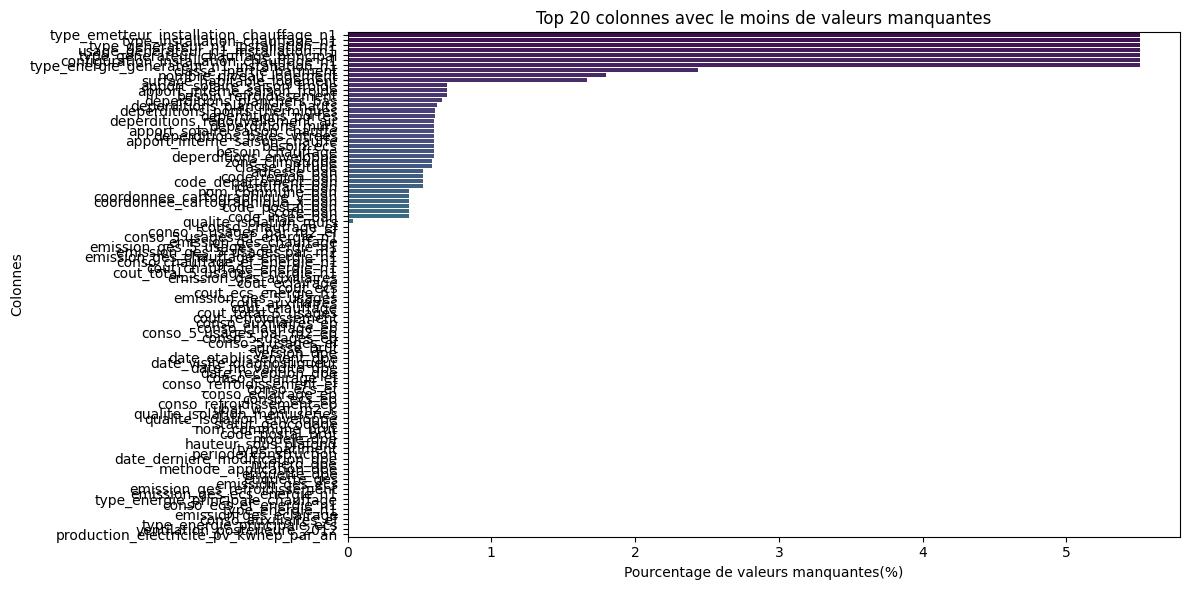

In [26]:
least_missing = missing_df.tail(100)

#Affichage avec seaborn
plt.figure(figsize=(12,6))
sns.barplot(x="missing_percentage", y="column_name", data= least_missing, palette="viridis")

plt.title("Top 20 colonnes avec le moins de valeurs manquantes")
plt.xlabel("Pourcentage de valeurs manquantes(%)")
plt.ylabel("Colonnes")
plt.tight_layout()
plt.show

C:\Users\Adnane.BEN-ALI\AppData\Local\Temp\ipykernel_4680\677167116.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="viridis")


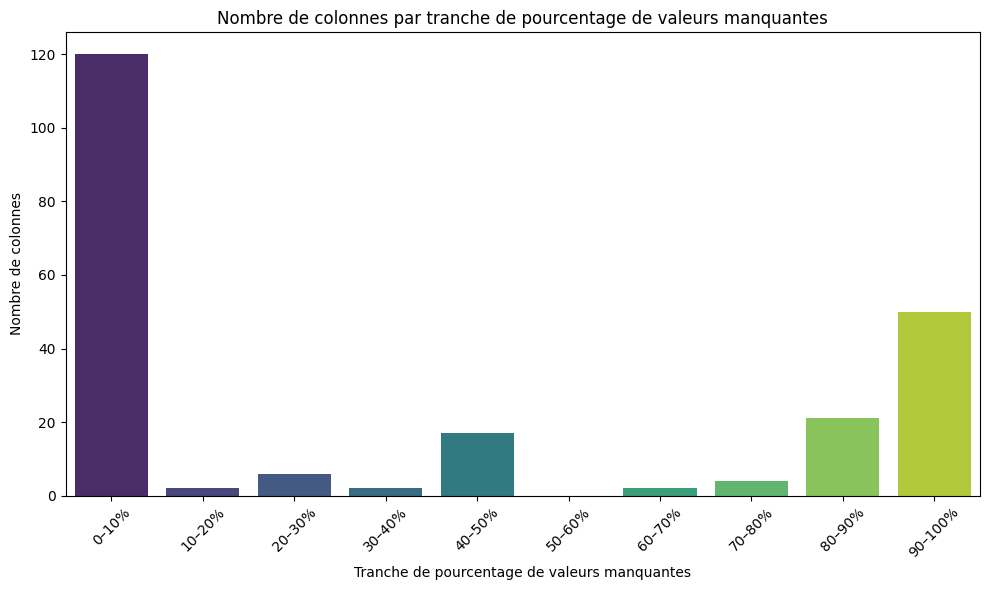

In [27]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [f"{i}–{i+10}%" for i in bins[:-1]]
missing_bins = pd.cut(missing_percent, bins=bins, labels=labels, include_lowest=True)

# Compte le nombre de colonnes dans chaque tranche
bin_counts = missing_bins.value_counts().sort_index()

# Affiche le histogramme
plt.figure(figsize=(10, 6))
sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="viridis")
plt.title("Nombre de colonnes par tranche de pourcentage de valeurs manquantes")
plt.xlabel("Tranche de pourcentage de valeurs manquantes")
plt.ylabel("Nombre de colonnes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### It would be good to see how many NA there is after suppression of every NA from target column

In [28]:
missing_NA_classe_dpe = df['etiquette_dpe'].isna().sum()

missing_NA_classe_dpe
# df_No_NA_class_dpe = 

np.int64(0)

Ok la table de base ici n'a pas de valeur manquante sur la variable cible. C'est bien

# Second analysis without na on class_bilan_dpe (TABLE: nona)

Chunk 1 - rows: 31500
 Memory usage: 195682.73828125
sys.getsizeof 195682.76953125
 sys.getsizeof : 191.1 MB

✅ Données chargées : (31500, 224)
📊 Mémoire totale estimée : 191.1 MB


C:\Users\Adnane.BEN-ALI\AppData\Local\Temp\ipykernel_4680\1428591926.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="viridis")


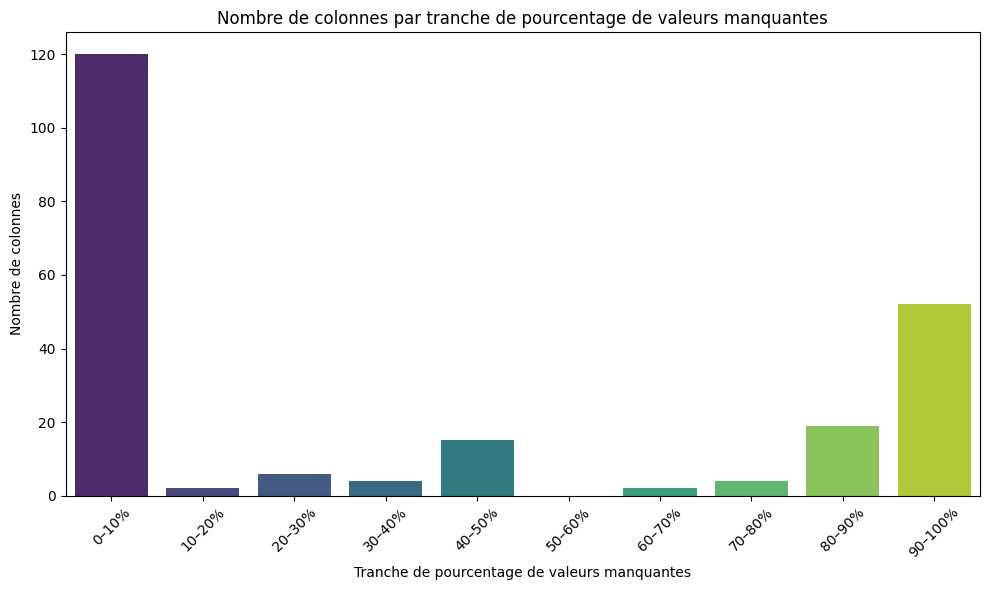

In [38]:
query2 = """
    SELECT *
    FROM dpe_equilibree_30k
"""
# query2 = """
#     SELECT *
#     FROM dpe_equilibree
# """
df_nona = data_processing(query2)

missing_percent = df_nona.isnull().mean().sort_values(ascending=False) * 100

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [f"{i}–{i+10}%" for i in bins[:-1]]
missing_bins = pd.cut(missing_percent, bins=bins, labels=labels, include_lowest=True)

# Compte le nombre de colonnes dans chaque tranche
bin_counts = missing_bins.value_counts().sort_index()

# Affiche le histogramme
plt.figure(figsize=(10, 6))
sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="viridis")
plt.title("Nombre de colonnes par tranche de pourcentage de valeurs manquantes")
plt.xlabel("Tranche de pourcentage de valeurs manquantes")
plt.ylabel("Nombre de colonnes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
missing_df = missing_percent.reset_index(name = 'percent_missing')

columns_between_percent = missing_df[missing_df['percent_missing'].between(50,60)]
print(columns_between_percent)

Empty DataFrame
Columns: [index, percent_missing]
Index: []


Conclusion: We can first try to delete the col with NA above 50% without thinking too much because we have a lot of cols. 
The variable from 10 to 50 seem really interesting so we may try to replace missing values by mean later to improve model.
The variables with NA More than 50 don't seem to be interesting. 

Next step: create new table called table2 with only cols with NA less than 10%

In [40]:
threshold = 0.10
missing_ratio = df_nona.isna().mean()
df_filtered = df_nona.loc[:,missing_ratio < threshold]

print(f"✅ Colonnes supprimer : {df_nona.shape[1] - df_filtered.shape[1]}")

✅ Colonnes supprimer : 104


In [41]:
def place_sql_table(table_to_create_from_dataframe):
    engine = create_engine(database_url)
    table_to_create_from_dataframe.to_sql("table2", engine, index=False, if_exists="replace")
    print("✅ Table `table2` créée dans la base SQL.")

In [42]:
from sqlalchemy import create_engine
import pandas as pd

longueur_max =len(df_nona)


query = f"""
SELECT
  string_agg(
    format(
      'SUM(CASE WHEN %%I IS NULL THEN 1 ELSE 0 END)*100/{longueur_max} AS %%I',
      column_name, column_name
    ),
    ', '
  ) AS cols_expr
FROM information_schema.columns
WHERE table_schema = 'public'
  AND table_name   = 'dpe_equilibree_30k'
"""
# query = f"""
# SELECT
#   string_agg(
#     format(
#       'SUM(CASE WHEN %%I IS NULL THEN 1 ELSE 0 END)*100/{longueur_max} AS %%I',
#       column_name, column_name
#     ),
#     ', '
#   ) AS cols_expr
# FROM information_schema.columns
# WHERE table_schema = 'public'
#   AND table_name   = 'dpe_equilibree'
# """

df_deux = data_processing(query)


Chunk 1 - rows: 1
 Memory usage: 24.3916015625
sys.getsizeof 24.4228515625
 sys.getsizeof : 24.39 KB

✅ Données chargées : (1, 1)
📊 Mémoire totale estimée : 24.39 KB


In [43]:
cols_expression = df_deux['cols_expr'].iloc[0]
print(df_deux)


                                           cols_expr
0  SUM(CASE WHEN numero_dpe IS NULL THEN 1 ELSE 0...


In [44]:
count_nulls_query = f"""
SELECT {cols_expression}
FROM dpe_equilibree_30k
"""
# count_nulls_query = f"""
# SELECT {cols_expression}
# FROM dpe_equilibree
# """
null_counts_df  = data_processing(count_nulls_query)
display(null_counts_df )


Chunk 1 - rows: 1
 Memory usage: 1.87890625
sys.getsizeof 1.91015625
 sys.getsizeof : 1.88 KB

✅ Données chargées : (1, 224)
📊 Mémoire totale estimée : 1.88 KB


,numero_dpe,date_derniere_modification_dpe,date_visite_diagnostiqueur,date_etablissement_dpe,date_reception_dpe,date_fin_validite_dpe,numero_dpe_remplace,numero_dpe_immeuble_associe,id_rnb,numero_rpls_logement,...,description_generateur_froid,surface_climatisee,conso_refroidissement_annuel,categorie_enr,systeme_production_electricite_origine_renouvelable,presence_production_pv,surface_totale_capteurs_pv,nombre_module,production_electricite_pv_kwhep_par_an,electricite_pv_autoconsommee
0,0,0,0,0,0,0,91,80,44,99,...,89,89,89,63,90,90,98,98,0,97


Ok la c'est bien j'ai les nom des colonnes avec leur pourcentage de valeurs manquante
Ce que je fais mtn c'est recup le nom des cols avec un pourcentage de valeur manquante inférieur à 10%
ensuite je create a Table a partir de ces nom de variable et c'est bon!

In [45]:
missing_df = missing_percent.reset_index(name = 'percent_missing')

columns_between_percent_2 = missing_df[missing_df['index'] == "qualite_isolation_plancher bas"]
display(columns_between_percent_2)
print(len(df_nona))

,index,percent_missing
107,qualite_isolation_plancher bas,6.520635


31500


In [46]:
null_counts_df.columns[143]

'type_emetteur_installation_chauffage_n1'

In [60]:
# query3 = ""

# for col in null_counts_df.columns:
#     if (null_counts_df[col][0] < 10):
#         if " " in col:
#             query3 += f'"{col}"' + ','
#         else:
#             query3 += col + ','

# print(query3[0:-1])
# query3 = query3[:-1]
# query = f"""CREATE TABLE dpe_equilibree_less_than_10p AS SELECT {query3} FROM dpe_equilibree;"""
query3 = ""

for col in null_counts_df.columns:
    if (null_counts_df[col][0] < 10):
        if " " in col:
            query3 += f'"{col}"' + ','
        else:
            query3 += col + ','

print(query3[0:-1])
# query3 = query3[:-1]
# query = f"""CREATE TABLE dpe_equilibree_30k_less_than_10p AS SELECT {query3} FROM dpe_equilibree_30k;"""
engine = create_engine(database_url)
# with engine.begin() as connection:
#     connection.execute(text(query))

df_clean = pd.read_sql("SELECT * FROM dpe_equilibree_30k_less_than_10p", engine)
# df_clean = pd.read_sql("SELECT * FROM dpe_equilibree_less_than_10p", engine)

numero_dpe,date_derniere_modification_dpe,date_visite_diagnostiqueur,date_etablissement_dpe,date_reception_dpe,date_fin_validite_dpe,modele_dpe,version_dpe,methode_application_dpe,etiquette_dpe,etiquette_ges,type_batiment,periode_construction,hauteur_sous_plafond,nombre_niveau_logement,surface_habitable_logement,classe_inertie_batiment,classe_altitude,zone_climatique,adresse_ban,nom_rue_ban,nom_commune_ban,code_postal_ban,code_insee_ban,code_departement_ban,code_region_ban,identifiant_ban,coordonnee_cartographique_x_ban,coordonnee_cartographique_y_ban,score_ban,statut_geocodage,adresse_brut,nom_commune_brut,code_postal_brut,deperditions_enveloppe,deperditions_ponts_thermiques,deperditions_murs,deperditions_planchers_hauts,deperditions_planchers_bas,deperditions_portes,deperditions_baies_vitrees,deperditions_renouvellement_air,qualite_isolation_enveloppe,qualite_isolation_murs,"qualite_isolation_plancher bas",qualite_isolation_menuiseries,ubat_w_par_m2_k,besoin_chauffage,besoin_ecs,beso

In [61]:
display(df_clean)

,numero_dpe,date_derniere_modification_dpe,date_visite_diagnostiqueur,date_etablissement_dpe,date_reception_dpe,date_fin_validite_dpe,modele_dpe,version_dpe,methode_application_dpe,etiquette_dpe,...,nombre_logements_desservis_par_installation_ecs_n1,surface_habitable_desservie_par_installation_ecs_n1,type_installation_solaire_n1,type_generateur_n1_ecs_n1,type_energie_generateur_n1_ecs_n1,usage_generateur_n1_ecs_n1,volume_stockage_generateur_n1_ecs_n1,conso_ef_generateur_n1_ecs_n1,ventilation_posterieure_2012,production_electricite_pv_kwhep_par_an
0,2250E0803657W,2024-02-06,2022-04-14,2022-04-14,2022-04-15,2032-04-13,DPE 3CL 2021 méthode logement,2.1,dpe maison individuelle,A,...,1.0,70.0,Non affecté,PAC double service après 2014,Électricité,chauffage + ecs,0.0,515.1,0,0.0
1,2263E0331723B,2024-02-06,2022-02-17,2022-02-17,2022-02-18,2032-02-16,DPE 3CL 2021 méthode logement,2.1,dpe maison individuelle,A,...,1.0,128.0,Non affecté,PAC double service après 2014,Électricité,chauffage + ecs,150.0,657.0,0,0.0
2,2265E1039038O,2024-12-30,2022-05-11,2022-05-12,2022-05-13,2032-05-11,DPE 3CL 2021 méthode logement,2.1,dpe maison individuelle,A,...,1.0,141.7,Non affecté,CET sur air extérieur après 2014,Électricité,ecs,300.0,628.2,0,0.0
3,2266E0549293G,2024-12-30,2022-03-15,2022-03-17,2022-03-18,2032-03-16,DPE 3CL 2021 méthode logement,2.1,dpe maison individuelle,A,...,1.0,123.1,Non affecté,CET sur air extérieur après 2014,Électricité,ecs,270.0,509.8,0,0.0
4,2233E0263715F,2024-12-30,2022-02-09,2022-02-09,2022-02-10,2032-02-08,DPE 3CL 2021 méthode logement,2.0,dpe maison individuelle,A,...,1.0,102.0,Non affecté,PAC double service après 2014,Électricité,ecs,0.0,550.5,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31495,2468E1686897K,2024-12-30,2024-05-13,2024-05-13,2024-05-14,2034-05-12,DPE 3CL 2021 méthode logement,2.3,dpe maison individuelle,G,...,1.0,118.5,Non affecté,Ballon électrique à accumulation vertical Autr...,Électricité,ecs,200.0,2549.7,0,0.0
31496,2471E0837985B,2024-12-12,2024-02-28,2024-03-06,2024-03-07,2034-03-05,DPE 3CL 2021 méthode logement,2.3,dpe appartement individuel,G,...,1.0,32.4,Non affecté,Chauffe-eau gaz à production instantanée avant...,Gaz naturel,ecs,0.0,4375.4,0,0.0
31497,2469E0920359F,2024-12-30,2024-03-12,2024-03-12,2024-03-13,2034-03-11,DPE 3CL 2021 méthode logement,2.3,dpe appartement individuel,G,...,1.0,32.5,Non affecté,Ballon électrique à accumulation horizontal,Électricité,ecs,150.0,1780.7,0,0.0
31498,2473E2138807T,2024-06-14,2024-06-13,2024-06-13,2024-06-14,2034-06-12,DPE 3CL 2021 méthode logement,2.3,dpe maison individuelle,G,...,1.0,70.0,Non affecté,Ballon électrique à accumulation vertical Caté...,Électricité,ecs,150.0,1917.3,0,0.0


# Step 3 (TABLE: dpe_equilibree_less_than_10p & dpe_equilibree_30k_less_than_10p)

In [62]:
query2 = """
    SELECT *
    FROM dpe_equilibree_30k_less_than_10p
"""
# query2 = """
#     SELECT *
#     FROM dpe_equilibree_less_than_10p
# """
df_clean = data_processing(query2)

Chunk 1 - rows: 31500
 Memory usage: 128854.7734375
sys.getsizeof 128854.8046875
 sys.getsizeof : 125.83 MB

✅ Données chargées : (31500, 120)
📊 Mémoire totale estimée : 125.83 MB


C:\Users\Adnane.BEN-ALI\AppData\Local\Temp\ipykernel_4680\2104997485.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="missing_percentage", y="column_name", data= top_missing, palette="viridis")


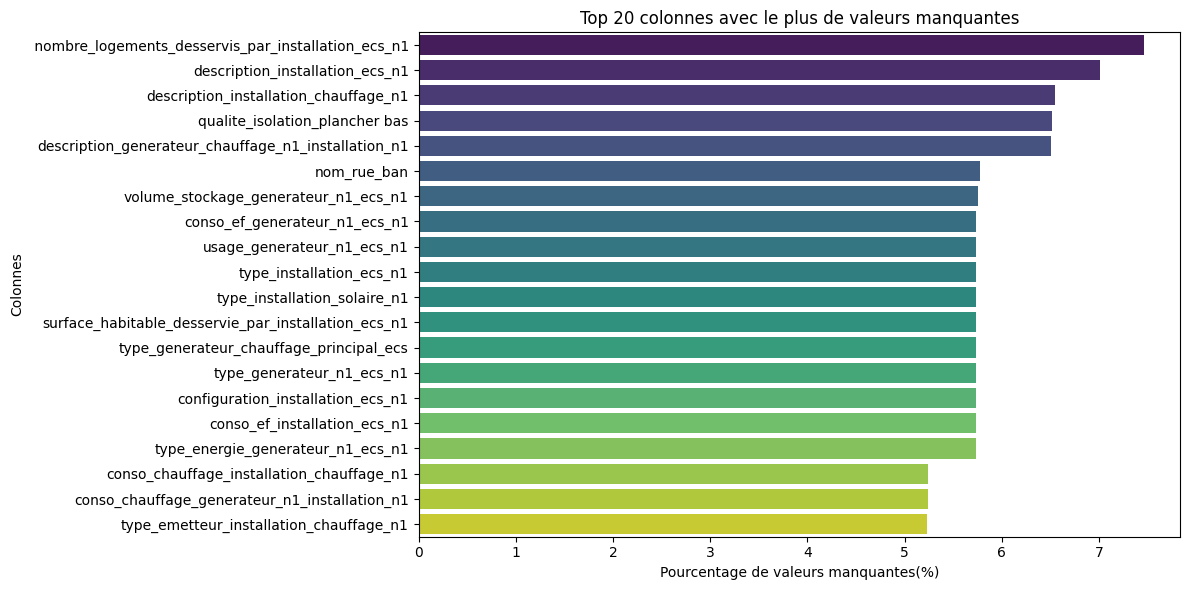

In [63]:
show_most_na_col(df_clean)

C:\Users\Adnane.BEN-ALI\AppData\Local\Temp\ipykernel_4680\2104997485.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="viridis")


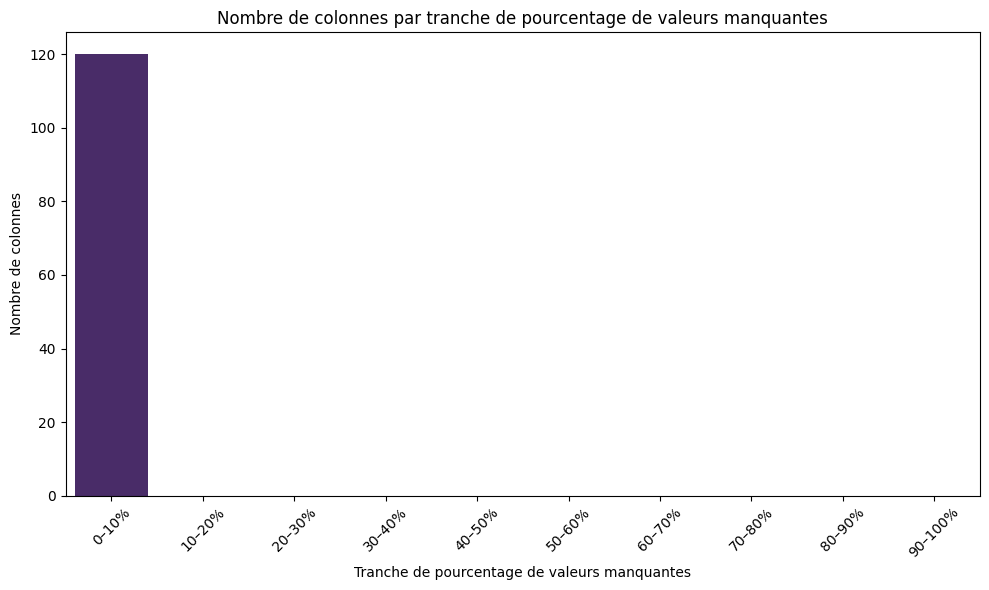

In [64]:
show_all_col_na(df_clean)

# Step 4: Voir les variables à faible variance et les supprimer

In [65]:
low_variance_info = []
df = df_clean

for col in df.columns:
    top_freq = df[col].value_counts(normalize=True, dropna=False).values[0]
    n_unique = df[col].nunique(dropna=False)
    
    low_variance_info.append({
        "colonne": col,
        "top_freq_ratio (%)": round(top_freq * 100, 2),
        "nb_modalités": n_unique,
        "alerte_low_variance": top_freq >= 0.95
    })

low_variance_df = pd.DataFrame(low_variance_info)
low_variance_df = low_variance_df.sort_values("top_freq_ratio (%)", ascending=False)

cols_to_drop = low_variance_df[low_variance_df["top_freq_ratio (%)"] > 85]["colonne"].tolist()

# Affiche les colonnes avec +95% des valeurs identiques
print(low_variance_df.head(20))

                                               colonne  top_freq_ratio (%)  \
6                                           modele_dpe              100.00   
119             production_electricite_pv_kwhep_par_an               98.38   
118                       ventilation_posterieure_2012               96.39   
17                                     classe_altitude               92.60   
112                       type_installation_solaire_n1               90.91   
107                  configuration_installation_ecs_n1               90.08   
72                        emission_ges_refroidissement               89.09   
58                            conso_refroidissement_ep               89.01   
65                            conso_refroidissement_ef               89.01   
88                                cout_refroidissement               89.00   
53                        apport_solaire_saison_froide               88.40   
49                              besoin_refroidissement          

In [66]:
# Nombre total de lignes
total_rows = 31500
# total_rows = 10500

# Sélection des colonnes qualitatives
qual_cols = df_clean.select_dtypes(include=['object', 'category']).columns

# Liste pour stocker les infos
unique_values_info = []

# Itération sur chaque colonne qualitative
for col in qual_cols:
    n_unique = df_clean[col].nunique(dropna=False)
    pct_unique = (n_unique / total_rows) * 100
    unique_values_info.append({
        'colonne': col,
        'pct_valeurs_uniques (%)': round(pct_unique, 2)
    })

# Conversion en DataFrame pour tri et inspection
df_unique_values = pd.DataFrame(unique_values_info)
df_unique_values = df_unique_values.sort_values(by='pct_valeurs_uniques (%)', ascending=False)

high_cardinality_cols = df_unique_values[df_unique_values['pct_valeurs_uniques (%)'] > 10]['colonne'].tolist()


# Affichage
print(df_unique_values)


                                              colonne  pct_valeurs_uniques (%)
0                                          numero_dpe                   100.00
22                                       adresse_brut                    93.02
15                                        adresse_ban                    92.14
20                                    identifiant_ban                    92.02
16                                        nom_rue_ban                    61.57
23                                   nom_commune_brut                    38.81
18                                     code_insee_ban                    26.70
17                                    nom_commune_ban                    26.40
34              description_installation_chauffage_n1                    12.77
43                    description_installation_ecs_n1                     4.57
3                              date_etablissement_dpe                     3.46
5                               date_fin_validite_dp

Pour l'instant on retire toutes les variables avec un top fréquence ratio supérieur a 90%. On pourra supprimer plus pour voir ensuite si ça améliore le modèle

In [67]:
all_cols_to_drop = list(set(cols_to_drop + high_cardinality_cols))
df_cleaned = df.drop(columns=all_cols_to_drop)
print(f"✅ {len(all_cols_to_drop)} colonnes supprimées. Nouveau shape: {df_cleaned.shape}")

✅ 24 colonnes supprimées. Nouveau shape: (31500, 96)


# Step 5: Voir la corrélation entre 2 variables

<class 'pandas.core.frame.DataFrame'>


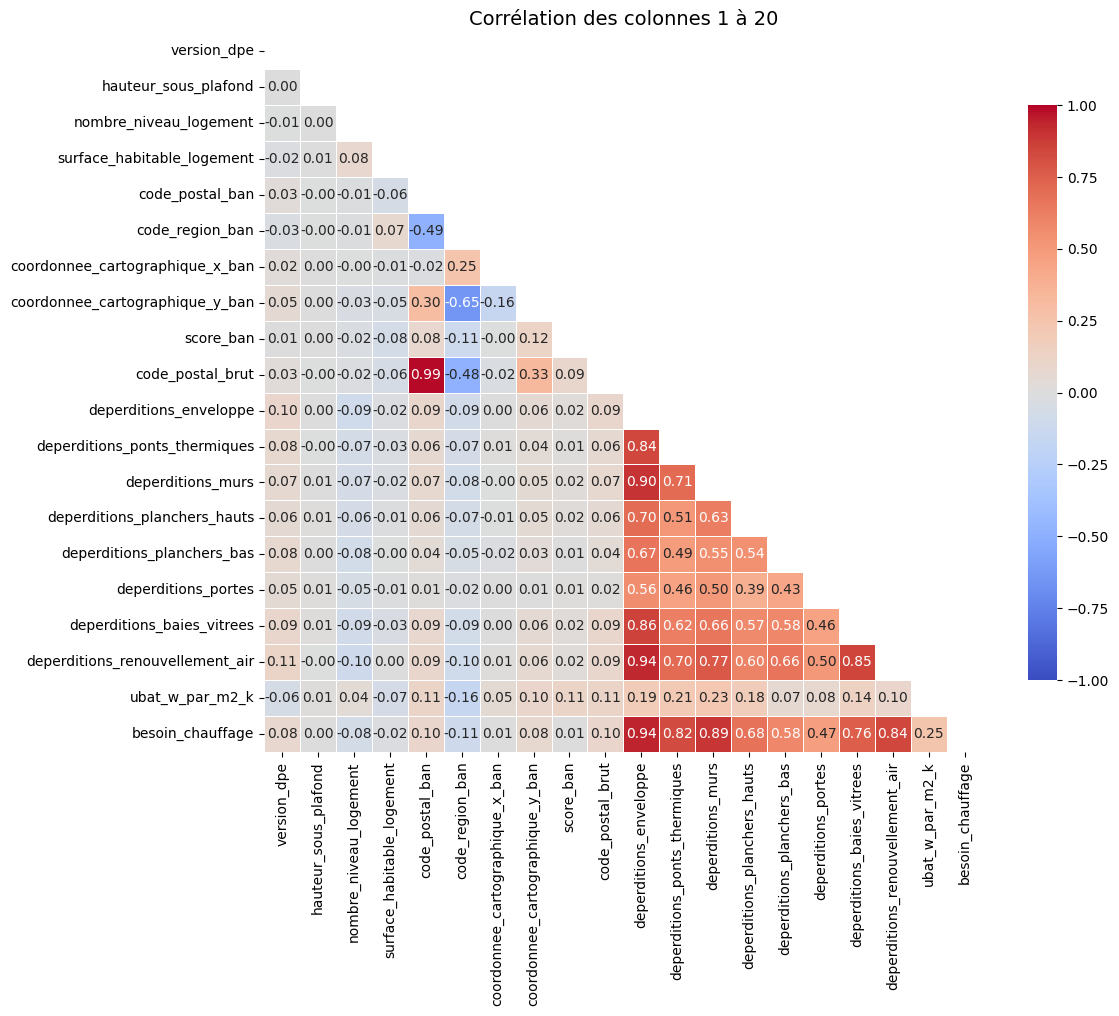

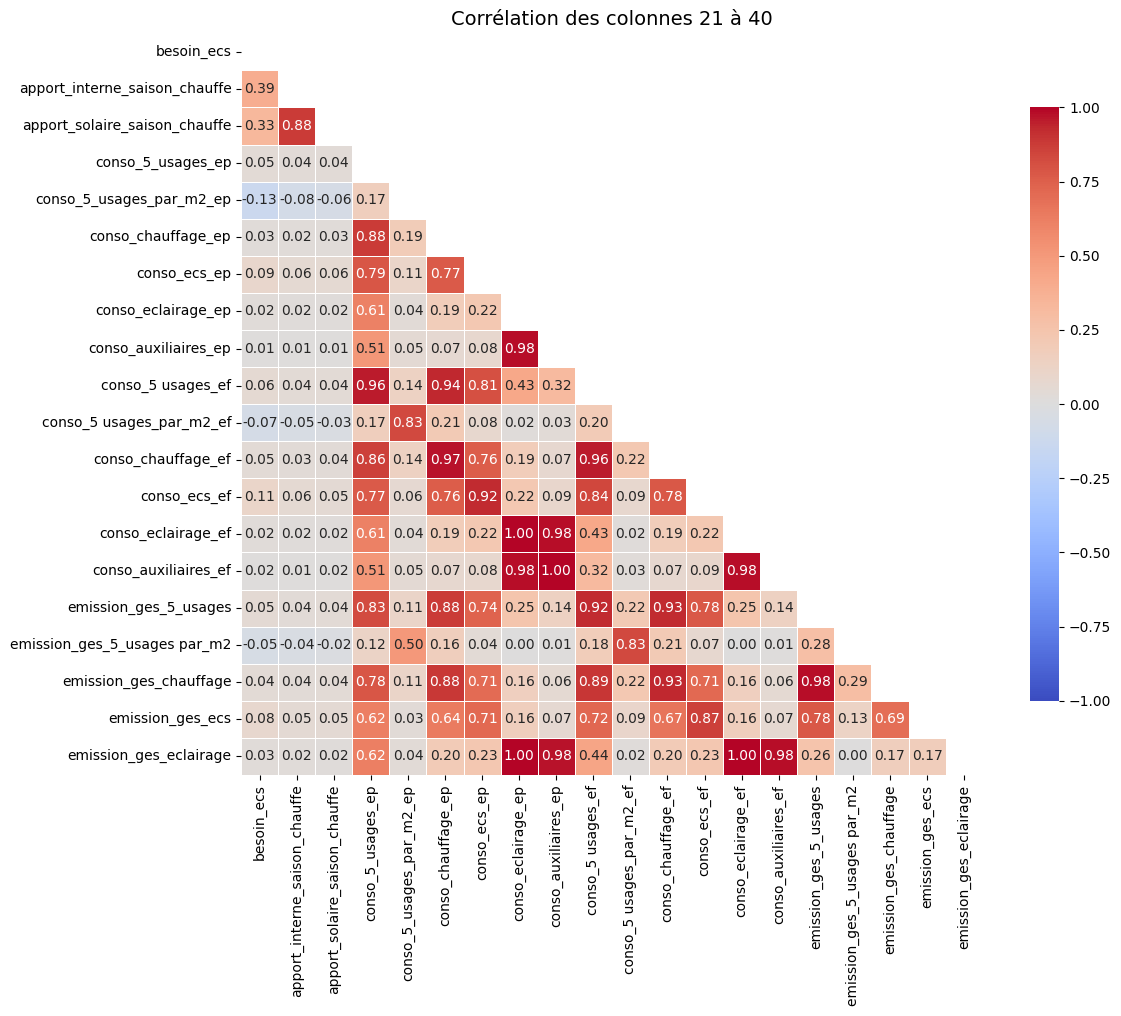

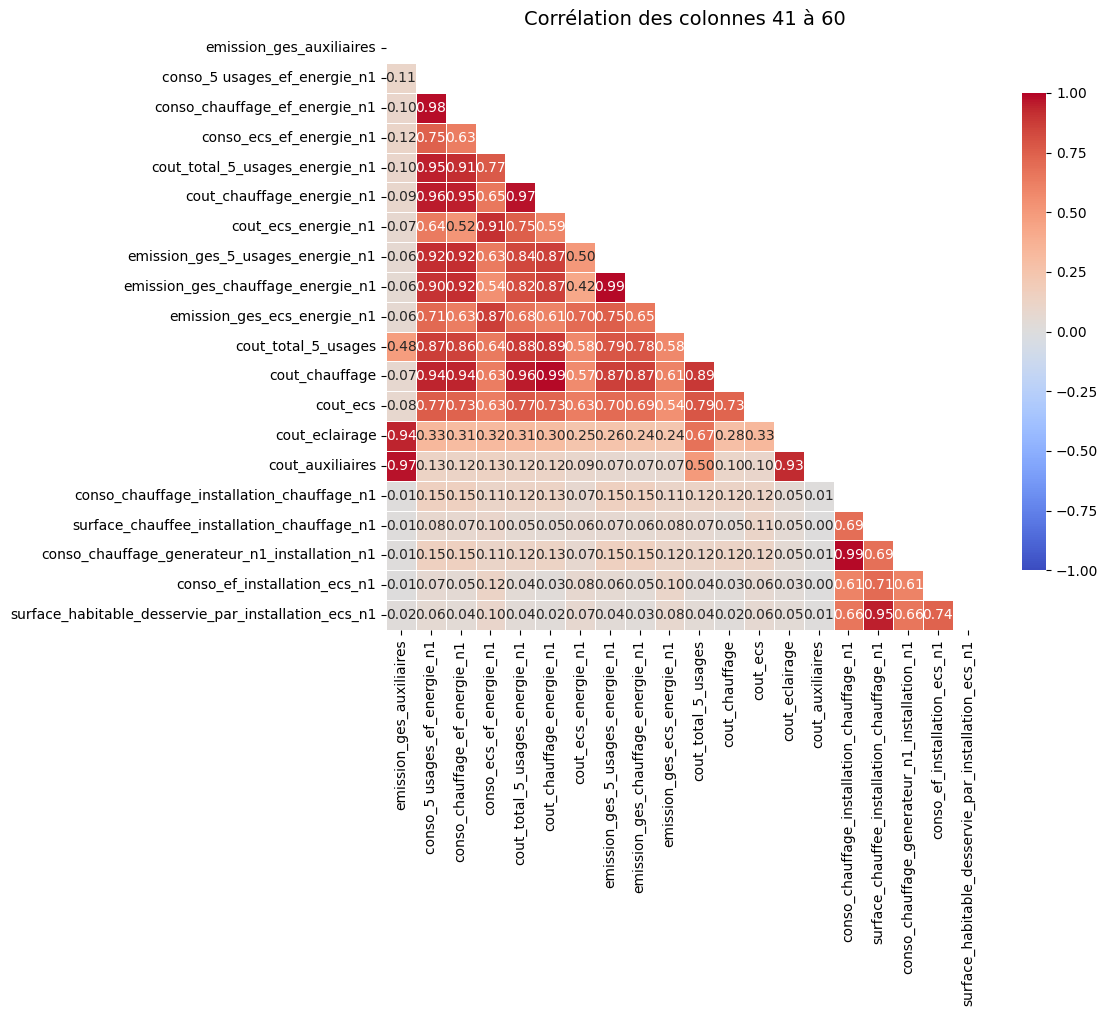

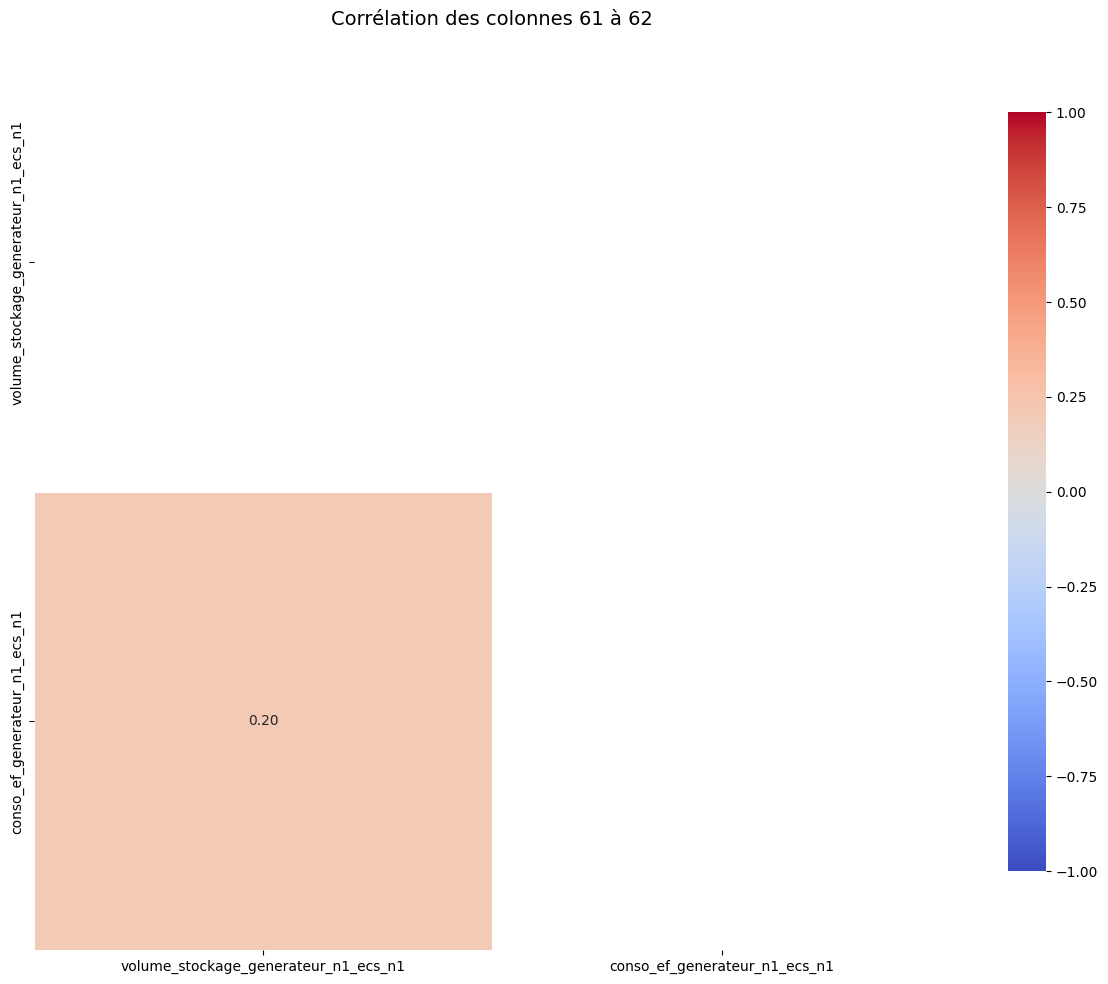

In [68]:


df = df_cleaned
print(type(df))
# Calcul de la matrice de corrélation

# On récupère juste les variables numériques
num_df = df.select_dtypes(include='number')
cols = num_df.columns
n_cols = len(cols)

# Taille des blocs
block_size = 20

for start in range(0, n_cols, block_size):
    end = min(start + block_size, n_cols)
    block_cols = cols[start:end]

    corr_block = num_df[block_cols].corr()

    # Plot
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_block, dtype=bool))

    sns.heatmap(
        corr_block,
        mask=mask,
        cmap='coolwarm',
        vmax=1.0,
        vmin=-1.0,
        annot=True,
        fmt=".2f",
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": .8}
    )

    plt.title(f'Corrélation des colonnes {start+1} à {end}', fontsize=14)
    plt.tight_layout()
    plt.show()


La y'a que 61 colonnes quantitative donc ça nous montre 4 heatmaps. Quand on trouve 2 colonnes fortement corrélé ( +90% de corrélation, on peut en supprimer une des deux (celle avec le moins de NA)) Encore un fois c'est un des paramètre qu'on peut réduire et voir ensuite l'impacte sur le modèle

In [69]:
df = df_cleaned

num_df = df.select_dtypes(include='number')

# Matrice de corrélation absolue
corr_matrix = num_df.corr().abs()

# Extraire la partie supérieure de la matrice
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Trouver les paires très corrélées (> 0.95)
high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.95]
# Calcule du pourcentage de valeurs manquantes par colonne
na_ratio = df.isna().mean()

# Ajout des colonnes de NA pour chaque feature
high_corr_pairs["NA_Feature1"] = high_corr_pairs["Feature1"].map(na_ratio)
high_corr_pairs["NA_Feature2"] = high_corr_pairs["Feature2"].map(na_ratio)

# Trier par corrélation décroissante
high_corr_pairs_sorted = high_corr_pairs.sort_values(by="Correlation", ascending=False)

# Affichage propre
pd.set_option("display.max_rows", 100)  # augmente le nombre de lignes affichées
display(high_corr_pairs_sorted[["Feature1", "Feature2", "Correlation", "NA_Feature1", "NA_Feature2"]])


,Feature1,Feature2,Correlation,NA_Feature1,NA_Feature2
1301,conso_eclairage_ep,conso_eclairage_ef,0.999991,0.000000,0.000000
1518,conso_auxiliaires_ef,emission_ges_auxiliaires,0.999859,0.000000,0.000063
1307,conso_eclairage_ep,emission_ges_eclairage,0.999703,0.000000,0.000000
1490,conso_eclairage_ef,emission_ges_eclairage,0.999684,0.000000,0.000000
1887,conso_ef_installation_ecs_n1,conso_ef_generateur_n1_ecs_n1,0.999579,0.057365,0.057365
1601,emission_ges_chauffage,emission_ges_chauffage_energie_n1,0.998388,0.000063,0.000063
1341,conso_auxiliaires_ep,emission_ges_auxiliaires,0.996876,0.000063,0.000063
1335,conso_auxiliaires_ep,conso_auxiliaires_ef,0.996796,0.000063,0.000000
209,surface_habitable_logement,conso_eclairage_ef,0.996345,0.013683,0.000000
203,surface_habitable_logement,conso_eclairage_ep,0.995310,0.013683,0.000000


In [70]:
# Supposons que df contient déjà les données nettoyées et numériques
df = df_cleaned

num_df = df.select_dtypes(include='number')

# Calculer la matrice de corrélation
corr_matrix = num_df.corr().abs()

# Pour éviter de re-check les mêmes paires, on met tout au-dessus de la diagonale à 0
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Liste des colonnes à supprimer
to_drop = []

for column in upper.columns:
    # On récupère les colonnes très corrélées avec celle-ci
    highly_corr = upper[column][upper[column] > 0.90].index.tolist()
    
    for other_col in highly_corr:
        na_column = df[column].isna().sum()
        na_other = df[other_col].isna().sum()

        # On garde celle qui a le moins de NA
        if na_column > na_other:
            to_drop.append(column)
        else:
            to_drop.append(other_col)

# Supprimer les doublons de la liste
to_drop = list(set(to_drop))

# Suppression
df_reduced = df.drop(columns=to_drop)

print(f"🔍 Colonnes supprimées car trop corrélées : {len(to_drop)}")
print("🗂️ Liste des colonnes supprimées :", to_drop)
df_reduced.shape

🔍 Colonnes supprimées car trop corrélées : 28
🗂️ Liste des colonnes supprimées : ['emission_ges_auxiliaires', 'surface_habitable_logement', 'emission_ges_ecs', 'conso_chauffage_installation_chauffage_n1', 'cout_total_5_usages_energie_n1', 'conso_eclairage_ef', 'conso_ecs_ep', 'conso_5 usages_ef_energie_n1', 'cout_eclairage', 'conso_eclairage_ep', 'deperditions_enveloppe', 'cout_ecs', 'conso_5_usages_ep', 'emission_ges_chauffage', 'cout_auxiliaires', 'cout_ecs_energie_n1', 'conso_chauffage_ef', 'conso_auxiliaires_ef', 'conso_ef_installation_ecs_n1', 'conso_5 usages_ef', 'conso_chauffage_ep', 'conso_auxiliaires_ep', 'emission_ges_5_usages', 'surface_habitable_desservie_par_installation_ecs_n1', 'cout_chauffage_energie_n1', 'code_postal_ban', 'conso_chauffage_ef_energie_n1', 'emission_ges_5_usages_energie_n1']


(31500, 68)

# Step 6: Modeles Random Forest avec et sans cross validation

Je supprime toutes les colonnes contenant le mot 'date'. Elles sont inutile dans ma prediction du dpe. Le fait de les enlever devrait accelerer le modèle.

In [71]:
df_reduced = df_reduced.loc[:, ~df_reduced.columns.str.contains('date', case=False)]
# df_reduced = df_reduced.loc[:, ~df_reduced.columns.str.contains('periode', case=False)]
df_reduced = df_reduced.loc[:, ~df_reduced.columns.str.contains('version_dpe', case=False)]
df_reduced = df_reduced.loc[:, ~df_reduced.columns.str.contains('methode_application_dpe', case=False)]
df_reduced = df_reduced.loc[:, ~df_reduced.columns.str.contains('conso_chauffage_ef_energie_n1', case=False)]

In [72]:
display(df_reduced.columns)

display(df_reduced)

Index(['etiquette_dpe', 'etiquette_ges', 'type_batiment',
       'periode_construction', 'hauteur_sous_plafond',
       'nombre_niveau_logement', 'classe_inertie_batiment', 'zone_climatique',
       'code_departement_ban', 'code_region_ban',
       'coordonnee_cartographique_x_ban', 'coordonnee_cartographique_y_ban',
       'score_ban', 'statut_geocodage', 'code_postal_brut',
       'deperditions_ponts_thermiques', 'deperditions_murs',
       'deperditions_planchers_hauts', 'deperditions_planchers_bas',
       'deperditions_portes', 'deperditions_baies_vitrees',
       'deperditions_renouvellement_air', 'qualite_isolation_enveloppe',
       'qualite_isolation_murs', 'qualite_isolation_plancher bas',
       'qualite_isolation_menuiseries', 'ubat_w_par_m2_k', 'besoin_chauffage',
       'besoin_ecs', 'apport_interne_saison_chauffe',
       'apport_solaire_saison_chauffe', 'conso_5_usages_par_m2_ep',
       'conso_5 usages_par_m2_ef', 'conso_ecs_ef',
       'emission_ges_5_usages par_m2', 

,etiquette_dpe,etiquette_ges,type_batiment,periode_construction,hauteur_sous_plafond,nombre_niveau_logement,classe_inertie_batiment,zone_climatique,code_departement_ban,code_region_ban,...,conso_chauffage_generateur_n1_installation_n1,type_energie_principale_ecs,type_generateur_chauffage_principal_ecs,type_installation_ecs_n1,description_installation_ecs_n1,type_generateur_n1_ecs_n1,type_energie_generateur_n1_ecs_n1,usage_generateur_n1_ecs_n1,volume_stockage_generateur_n1_ecs_n1,conso_ef_generateur_n1_ecs_n1
0,A,A,maison,2013-2021,2.5,1.0,Légère,H2a,50,28.0,...,778.2,Électricité,PAC double service après 2014,installation individuelle,Combiné au système de chauffage,PAC double service après 2014,Électricité,chauffage + ecs,0.0,515.1
1,A,A,maison,avant 1948,2.6,2.0,Légère,H1c,63,84.0,...,2619.5,Électricité,PAC double service après 2014,installation individuelle,"Combiné au système de chauffage, contenance ba...",PAC double service après 2014,Électricité,chauffage + ecs,150.0,657.0
2,A,A,maison,2013-2021,2.5,2.0,Légère,H2c,65,76.0,...,4570.8,Électricité,CET sur air extérieur après 2014,installation individuelle,Chauffe-eau thermodynamique sur air extérieur ...,CET sur air extérieur après 2014,Électricité,ecs,300.0,628.2
3,A,A,maison,2013-2021,2.5,2.0,Lourde,H3,66,76.0,...,970.0,Électricité,CET sur air extérieur après 2014,installation individuelle,Chauffe eau thermodynamique à accumulation,CET sur air extérieur après 2014,Électricité,ecs,270.0,509.8
4,A,A,maison,après 2021,2.5,1.0,Lourde,H2c,33,75.0,...,1256.5,Électricité,PAC double service après 2014,installation individuelle,Chauffe-eau thermodynamique ou PAC double service,PAC double service après 2014,Électricité,ecs,0.0,550.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31495,G,C,maison,1948-1974,2.5,2.0,Lourde,H1b,68,44.0,...,47808.6,Électricité,Ballon électrique à accumulation vertical Autr...,installation individuelle,Ballon électrique à accumulation vertical (aut...,Ballon électrique à accumulation vertical Autr...,Électricité,ecs,200.0,2549.7
31496,G,F,appartement,avant 1948,2.5,1.0,Lourde,H1c,71,27.0,...,9763.0,Gaz naturel,Chauffe-eau gaz à production instantanée avant...,installation individuelle,Chauffe-eau gaz à production instantanée insta...,Chauffe-eau gaz à production instantanée avant...,Gaz naturel,ecs,0.0,4375.4
31497,G,C,appartement,avant 1948,2.5,1.0,Légère,H1c,69,84.0,...,6989.9,Électricité,Ballon électrique à accumulation horizontal,installation individuelle,"Ballon électrique à accumulation horizontal, c...",Ballon électrique à accumulation horizontal,Électricité,ecs,150.0,1780.7
31498,G,C,maison,avant 1948,2.2,2.0,Moyenne,H1c,73,84.0,...,12771.0,Électricité,Ballon électrique à accumulation vertical Caté...,installation individuelle,Ballon électrique à accumulation vertical (cat...,Ballon électrique à accumulation vertical Caté...,Électricité,ecs,150.0,1917.3


In [73]:
row0_dict = df_reduced.iloc[0].to_dict()
import pprint
pprint.pprint(row0_dict)

{'apport_interne_saison_chauffe': 2251252.3,
 'apport_solaire_saison_chauffe': 1974471.0,
 'besoin_chauffage': 1851.9,
 'besoin_ecs': 1101.8,
 'classe_inertie_batiment': 'Légère',
 'code_departement_ban': '50',
 'code_postal_brut': 50190,
 'code_region_ban': 28.0,
 'conso_5 usages_par_m2_ef': 24.0,
 'conso_5_usages_par_m2_ep': 57.0,
 'conso_chauffage_generateur_n1_installation_n1': 778.2,
 'conso_ecs_ef': 515.1,
 'conso_ecs_ef_energie_n1': 515.1,
 'conso_ef_generateur_n1_ecs_n1': 515.1,
 'coordonnee_cartographique_x_ban': 378135.6,
 'coordonnee_cartographique_y_ban': 6901705.94,
 'cout_chauffage': 176.1,
 'cout_total_5_usages': 393.7,
 'deperditions_baies_vitrees': 11.2,
 'deperditions_murs': 7.1,
 'deperditions_planchers_bas': 11.5,
 'deperditions_planchers_hauts': 2.6,
 'deperditions_ponts_thermiques': 1.4,
 'deperditions_portes': 9.7,
 'deperditions_renouvellement_air': 29.5,
 'description_generateur_chauffage_n1_installation_n1': 'Electrique - PAC '
                                

In [74]:
df_reduced.to_pickle('df_reduced.pkl')

(31500, 2498)

Test Accuracy : 0.93

Classification Report :
               precision    recall  f1-score   support

           A       0.97      0.95      0.96       885
           B       0.89      0.97      0.93       918
           C       0.94      0.92      0.93       917
           D       0.95      0.93      0.93       894
           E       0.90      0.94      0.92       884
           F       0.93      0.88      0.90       915
           G       0.97      0.96      0.96       887

    accuracy                           0.93      6300
   macro avg       0.94      0.93      0.93      6300
weighted avg       0.93      0.93      0.93      6300



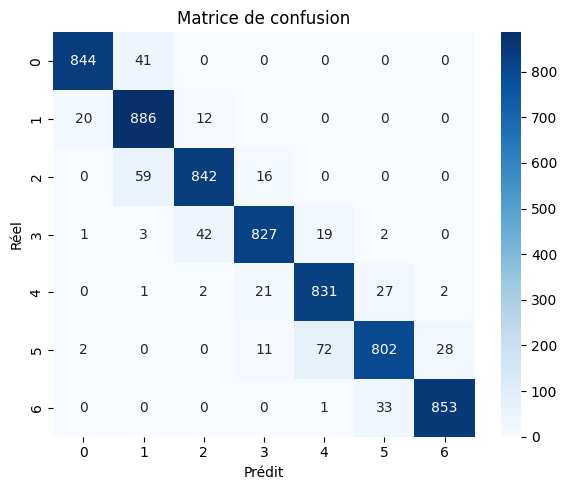

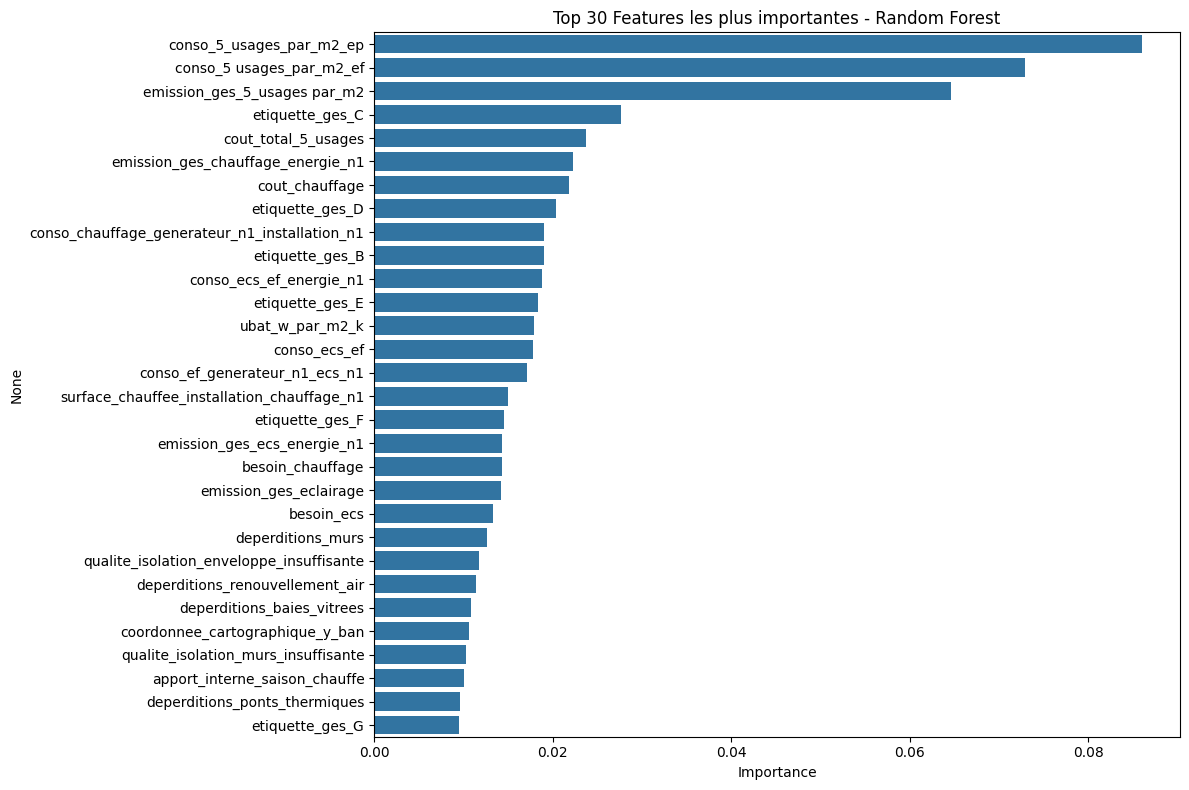

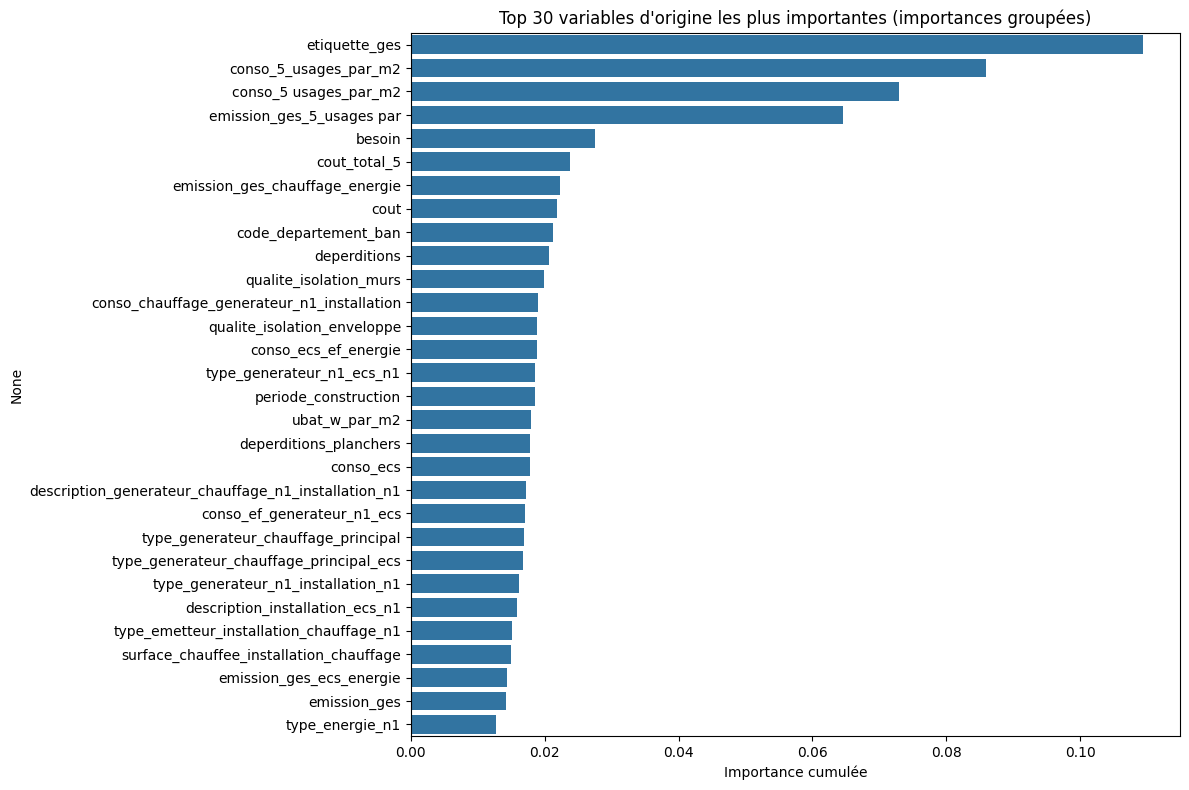

In [75]:
cross_train_report_rf(df_reduced, False)


# More tests (not super useful right now)

In [52]:
target_col = 'etiquette_dpe'
df = df_reduced
X = df.drop(columns=[target_col])
qualitative_cols = X.select_dtypes(include=['object', 'category']).columns
quantitative_cols = X.select_dtypes(include=['number']).columns
pd.get_dummies(df_reduced, columns=qualitative_cols, drop_first=True)

,version_dpe,etiquette_dpe,hauteur_sous_plafond,nombre_niveau_logement,code_region_ban,coordonnee_cartographique_x_ban,coordonnee_cartographique_y_ban,score_ban,code_postal_brut,deperditions_ponts_thermiques,...,type_energie_generateur_n1_ecs_n1_Butane,type_energie_generateur_n1_ecs_n1_Fioul domestique,type_energie_generateur_n1_ecs_n1_GPL,type_energie_generateur_n1_ecs_n1_Gaz naturel,type_energie_generateur_n1_ecs_n1_Propane,type_energie_generateur_n1_ecs_n1_Réseau de Chauffage urbain,type_energie_generateur_n1_ecs_n1_Électricité,type_energie_generateur_n1_ecs_n1_Électricité d'origine renouvelable utilisée dans le bâtiment,usage_generateur_n1_ecs_n1_chauffage + ecs,usage_generateur_n1_ecs_n1_ecs
0,2.1,A,2.5,1.0,93.0,1030391.03,6286468.25,0.64,6600,7.0,...,False,False,False,False,False,False,True,False,False,True
1,2.1,A,2.5,1.0,27.0,854515.12,6692797.76,0.75,21000,57.3,...,False,False,False,False,False,False,True,False,False,True
2,2.0,A,2.5,4.0,27.0,939001.50,6671732.26,0.63,25290,37.5,...,False,False,False,False,False,False,True,False,False,True
3,2.1,A,2.5,2.0,44.0,957380.62,6838097.70,0.96,54300,51.5,...,False,False,False,False,False,False,True,False,True,False
4,2.1,A,2.4,1.0,75.0,397700.10,6526458.54,0.86,17250,0.0,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31495,2.3,G,2.6,2.0,53.0,158414.41,6813424.93,0.46,29550,17.0,...,False,False,True,False,False,False,False,False,False,True
31496,2.3,G,2.8,2.0,53.0,347060.05,6792249.46,0.54,35740,87.4,...,False,False,False,False,False,False,True,False,False,True
31497,2.3,G,2.7,1.0,84.0,914962.05,6457191.84,0.89,38100,43.1,...,False,False,False,False,False,False,True,False,False,True
31498,2.3,G,2.6,2.0,32.0,655940.22,7068567.27,0.95,59173,103.1,...,False,False,False,False,False,False,True,False,False,True


In [53]:
nb = []
for name in qualitative_cols:
    nb.append(len(df_reduced[name].unique()))

In [54]:
len(qualitative_cols)

33

In [55]:
print("max number of unique values :",np.max(nb))
print("min number of unique values :",np.min(nb))
print("mean number of unique values :",np.mean(nb))
print("median number of unique values :",np.median(nb))

max number of unique values : 1442
min number of unique values : 2
mean number of unique values : 211.3030303030303
median number of unique values : 13.0


In [56]:
nb

[152,
 1019,
 1088,
 1089,
 1087,
 6,
 7,
 3,
 10,
 5,
 10,
 99,
 2,
 4,
 5,
 5,
 4,
 13,
 13,
 131,
 5,
 49,
 136,
 13,
 3,
 339,
 13,
 100,
 4,
 1442,
 100,
 13,
 4]

### Cross validation 5 times


(31500, 6957)
Cross-Validation Accuracy: 0.91 ± 0.01

Test Accuracy : 0.92

Classification Report :
               precision    recall  f1-score   support

           A       0.97      0.97      0.97       885
           B       0.89      0.96      0.93       918
           C       0.92      0.88      0.90       918
           D       0.92      0.89      0.90       893
           E       0.89      0.92      0.90       885
           F       0.92      0.88      0.90       916
           G       0.95      0.94      0.94       885

    accuracy                           0.92      6300
   macro avg       0.92      0.92      0.92      6300
weighted avg       0.92      0.92      0.92      6300



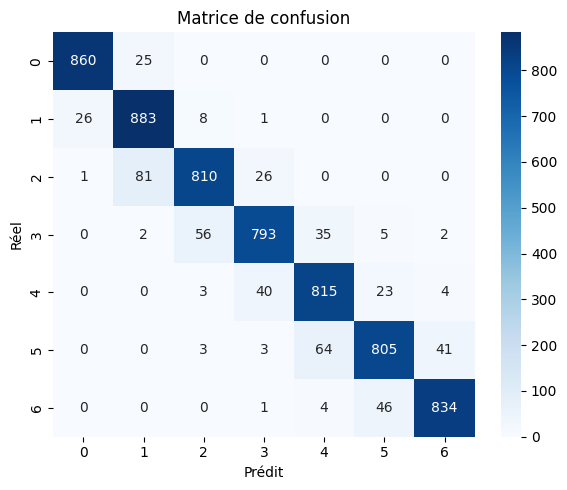

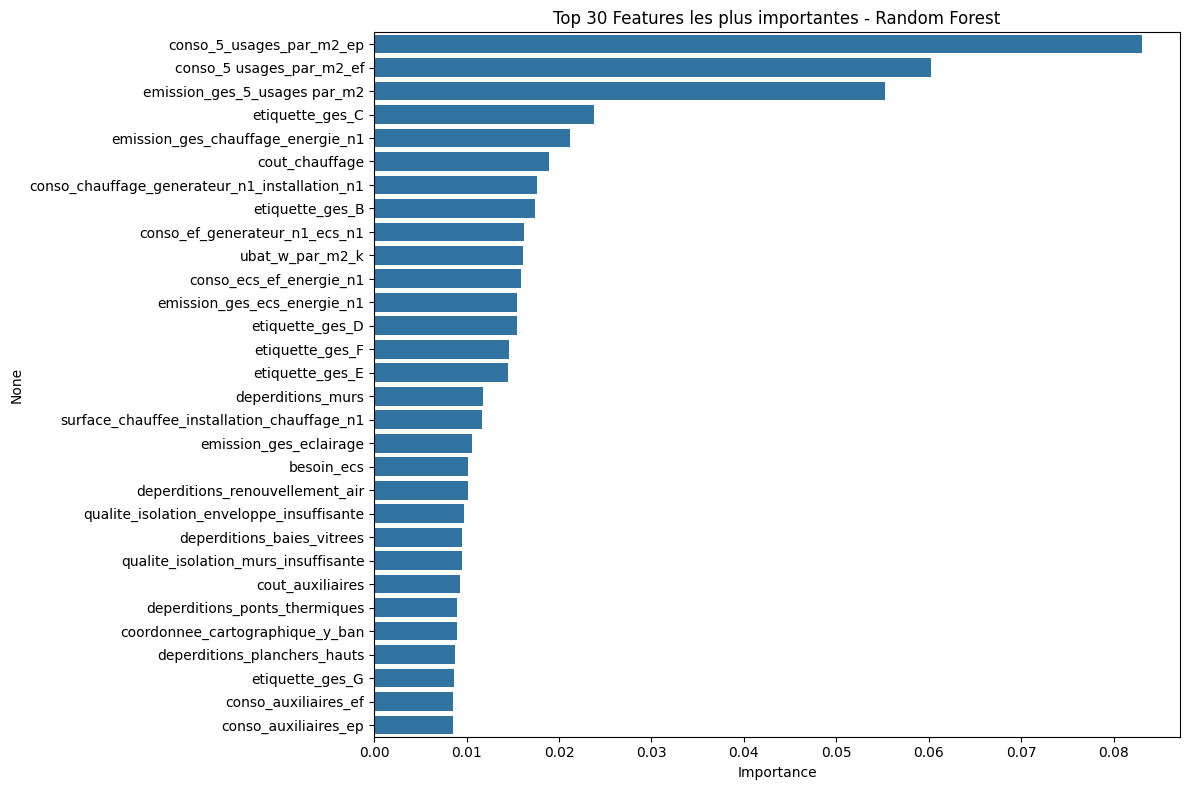

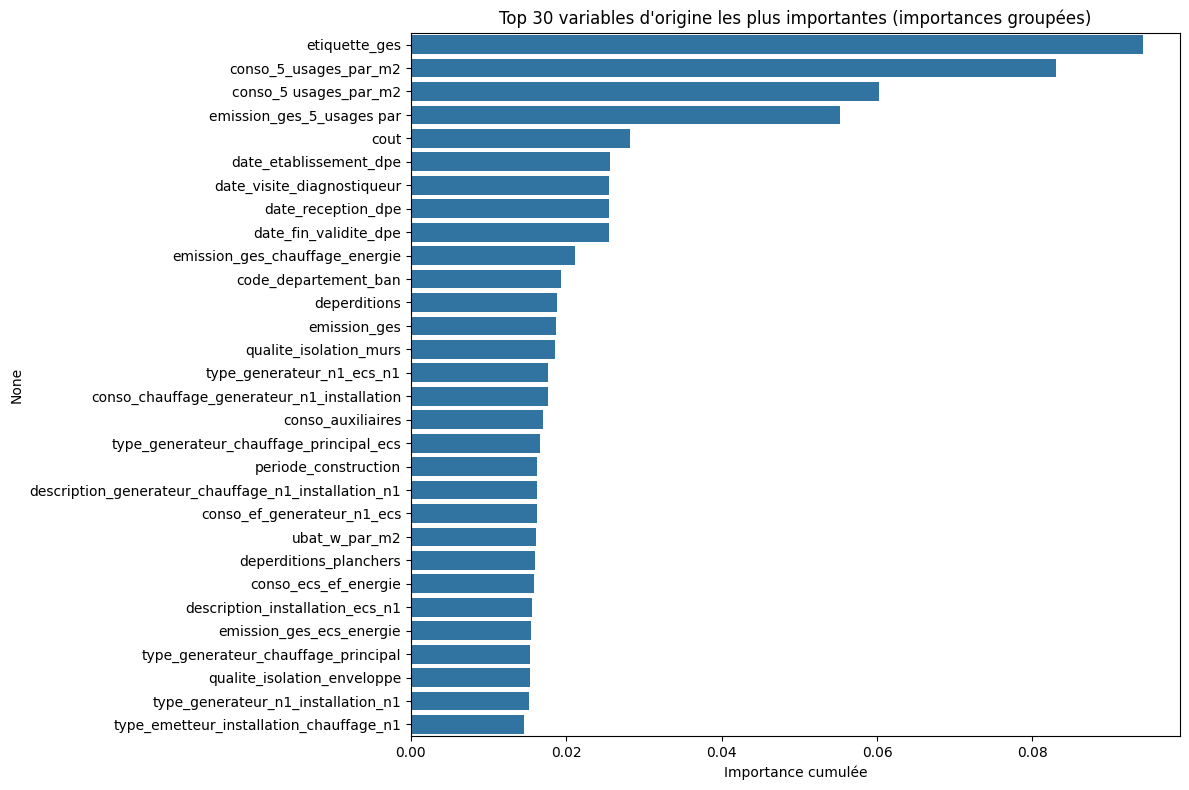

In [57]:
cross_train_report_rf(df_reduced, cv=True)

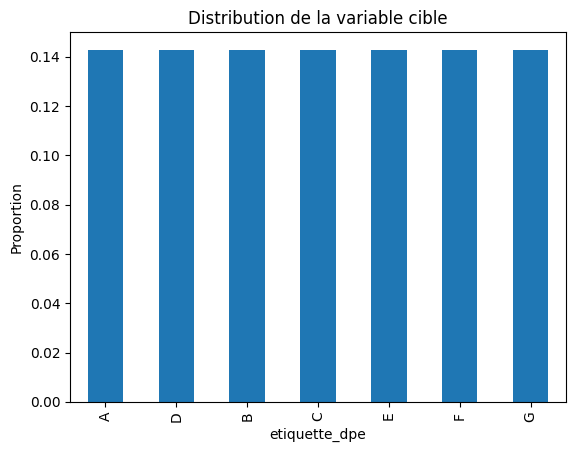

In [58]:
y = df[target_col]
y.value_counts(normalize=True).plot(kind='bar', title="Distribution de la variable cible")
plt.ylabel("Proportion")
plt.show()


### Testing with less variables

(31500, 2521)
Top 1 features → Accuracy: 0.8267
Top 3 features → Accuracy: 0.9611
Top 10 features → Accuracy: 0.9862
Top 20 features → Accuracy: 0.9863
Top 25 features → Accuracy: 0.9867
Top 30 features → Accuracy: 0.9871
Top 35 features → Accuracy: 0.9841
Top 40 features → Accuracy: 0.9851
Top 45 features → Accuracy: 0.9852
Top 50 features → Accuracy: 0.9844
Top 55 features → Accuracy: 0.9827
Top 60 features → Accuracy: 0.9832
Top 65 features → Accuracy: 0.9841
Top 70 features → Accuracy: 0.9819


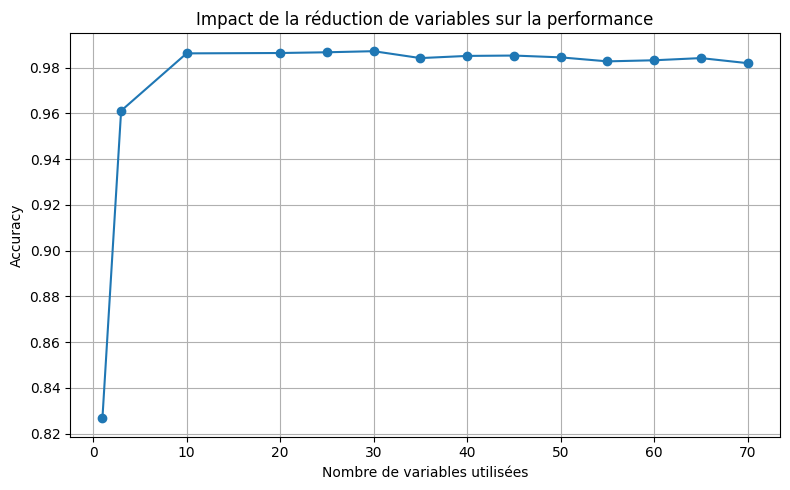

In [148]:
features_counts = [1,3,10, 20, 25, 30, 35, 40, 45, 50 , 55, 60, 65, 70]  # [70, 80, 90, 100]
cross_train_report_rf(df_reduced, feature_list_number=features_counts, cv=False)

(31500, 6957)


['conso_ecs_ef_energie_n1',
 'emission_ges_ecs_energie_n1',
 'etiquette_ges_D',
 'etiquette_ges_F',
 'etiquette_ges_E',
 'deperditions_murs',
 'surface_chauffee_installation_chauffage_n1',
 'emission_ges_eclairage',
 'besoin_ecs',
 'deperditions_renouvellement_air',
 'qualite_isolation_enveloppe_insuffisante',
 'deperditions_baies_vitrees',
 'qualite_isolation_murs_insuffisante',
 'cout_auxiliaires',
 'deperditions_ponts_thermiques',
 'coordonnee_cartographique_y_ban',
 'deperditions_planchers_hauts',
 'etiquette_ges_G',
 'conso_auxiliaires_ef',
 'conso_auxiliaires_ep',
 'apport_interne_saison_chauffe',
 'emission_ges_auxiliaires',
 'apport_solaire_saison_chauffe',
 'coordonnee_cartographique_x_ban',
 'qualite_isolation_murs_très bonne',
 'code_postal_brut',
 'deperditions_planchers_bas',
 'deperditions_portes',
 'score_ban',
 'volume_stockage_generateur_n1_ecs_n1',
 'periode_construction_2013-2021',
 'code_region_ban',
 'type_energie_principale_chauffage_Gaz naturel',
 'type_energie_n

Cross-Validation Accuracy: 0.69 ± 0.01

Classification Report :
               precision    recall  f1-score   support

           A       0.77      0.92      0.84       885
           B       0.70      0.65      0.67       918
           C       0.75      0.64      0.69       918
           D       0.68      0.69      0.68       893
           E       0.63      0.60      0.62       885
           F       0.70      0.56      0.62       916
           G       0.67      0.85      0.75       885

    accuracy                           0.70      6300
   macro avg       0.70      0.70      0.70      6300
weighted avg       0.70      0.70      0.70      6300



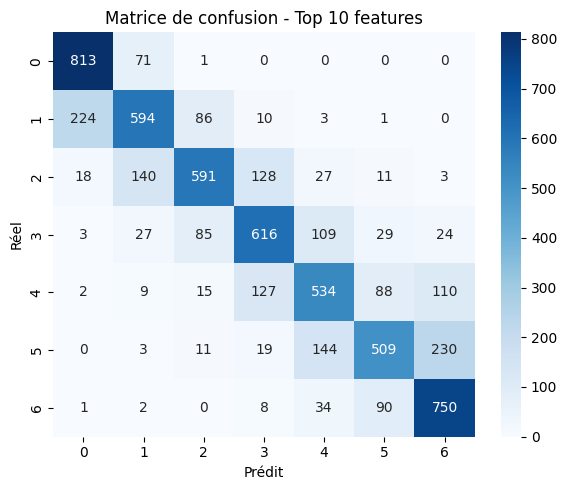

In [60]:
cross_train_report_rf(df_reduced, feature_number=10, cv=False)

In [61]:
cross_train_report_rf(df_reduced, feature_number=5, cv=False)

(31500, 6957)


['cout_chauffage',
 'conso_chauffage_generateur_n1_installation_n1',
 'etiquette_ges_B',
 'conso_ef_generateur_n1_ecs_n1',
 'ubat_w_par_m2_k',
 'conso_ecs_ef_energie_n1',
 'emission_ges_ecs_energie_n1',
 'etiquette_ges_D',
 'etiquette_ges_F',
 'etiquette_ges_E',
 'deperditions_murs',
 'surface_chauffee_installation_chauffage_n1',
 'emission_ges_eclairage',
 'besoin_ecs',
 'deperditions_renouvellement_air',
 'qualite_isolation_enveloppe_insuffisante',
 'deperditions_baies_vitrees',
 'qualite_isolation_murs_insuffisante',
 'cout_auxiliaires',
 'deperditions_ponts_thermiques',
 'coordonnee_cartographique_y_ban',
 'deperditions_planchers_hauts',
 'etiquette_ges_G',
 'conso_auxiliaires_ef',
 'conso_auxiliaires_ep',
 'apport_interne_saison_chauffe',
 'emission_ges_auxiliaires',
 'apport_solaire_saison_chauffe',
 'coordonnee_cartographique_x_ban',
 'qualite_isolation_murs_très bonne',
 'code_postal_brut',
 'deperditions_planchers_bas',
 'deperditions_portes',
 'score_ban',
 'volume_stockage_g

KeyboardInterrupt: 

# Step 7: Faire en sorte de pouvoir faire un modèle avec n'importe quelle variable que le user choisira et leur montrer la precision de la prediction

✅ Test Accuracy: 0.90
🔮 Prédiction sur données utilisateur : A


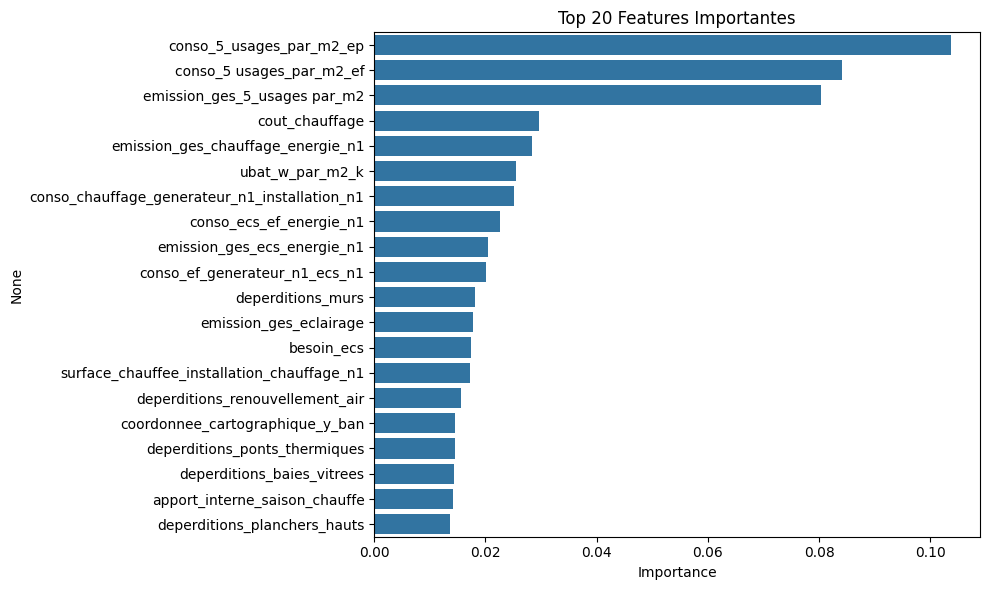

In [87]:
user_data = {
    'apport_interne_saison_chauffe': 1077425.6,
    'apport_solaire_saison_chauffe': 1030843.1,
    'besoin_ecs': 865.5,
    'classe_inertie_batiment': 'Lourde',
    # # 'code_departement_ban': '06',
    # 'code_postal_brut': 6600,
    'code_region_ban': 93.0,
    'conso_5 usages_par_m2_ef': 23.0,
    'conso_5_usages_par_m2_ep': 54.0,
    ## 'conso_auxiliaires_ef': 234.2,
    ## 'conso_auxiliaires_ep': 538.6,
    'conso_chauffage_generateur_n1_installation_n1': 332.4,
    'conso_ecs_ef_energie_n1': 320.9,
    'conso_ef_generateur_n1_ecs_n1': 320.9,
    'coordonnee_cartographique_x_ban': 1030391.03,
    'coordonnee_cartographique_y_ban': 6286468.25,
    ##'cout_auxiliaires': 38.1,
    'cout_chauffage': 96.4,
    'deperditions_baies_vitrees': 17.6,
    'deperditions_murs': 4.5,
    'deperditions_planchers_bas': 0.0,
    'deperditions_planchers_hauts': 0.0,
    'deperditions_ponts_thermiques': 7.0,
    'deperditions_portes': 0.0,
    'deperditions_renouvellement_air': 19.8,
    'description_generateur_chauffage_n1_installation_n1': 'Electrique - Convecteur électrique NFC, NF** et NF***',
    'description_installation_ecs_n1': 'Chauffe-eau thermodynamique sur air extrait installé à partir de 2015, contenance ballon 200 L',
    'emission_ges_5_usages par_m2': 1.0,
    ## 'emission_ges_auxiliaires': 15.0,
    'emission_ges_chauffage_energie_n1': 26.3,
    'emission_ges_eclairage': 5.3,
    'emission_ges_ecs_energie_n1': 20.9,
    # 'etiquette_ges': 'A',
    'hauteur_sous_plafond': 2.5,
    'nombre_niveau_logement': 1.0,
    'periode_construction': '2006-2012',
    'qualite_isolation_enveloppe': 'insuffisante',
    'qualite_isolation_menuiseries': 'moyenne',
    'qualite_isolation_murs': 'bonne',
    'qualite_isolation_plancher bas': 'très bonne',
    # 'score_ban': 0.64,
    # 'statut_geocodage': "adresse géocodée ban à l'adresse",
    'surface_chauffee_installation_chauffage_n1': 40.4,
    'type_batiment': 'appartement',
    'type_emetteur_installation_chauffage_n1': 'Convecteur électrique NFC, NF** et NF***',
    'type_energie_generateur_n1_ecs_n1': 'Électricité',
    'type_energie_generateur_n1_installation_n1': 'Électricité',
    'type_energie_n1': 'Électricité',
    'type_energie_principale_chauffage': 'Électricité',
    'type_energie_principale_ecs': 'Électricité',
    'type_generateur_chauffage_principal': 'Convecteur électrique NFC, NF** et NF***',
    'type_generateur_chauffage_principal_ecs': 'CET sur air extrait après 2014',
    'type_generateur_n1_ecs_n1': 'CET sur air extrait après 2014',
    'type_generateur_n1_installation_n1': 'Convecteur électrique NFC, NF** et NF***',
    'type_installation_chauffage_n1': 'installation individuelle',
    'type_installation_ecs_n1': 'installation individuelle',
    'ubat_w_par_m2_k': 1.53,
    'usage_generateur_n1_ecs_n1': 'ecs',
    'usage_generateur_n1_installation_n1': 'chauffage',
    'volume_stockage_generateur_n1_ecs_n1': 200.0,
    'zone_climatique': 'H3'
}


prediction, acc = train_predict_from_user_input(df_reduced, user_data )

c:\Users\Adnane.BEN-ALI\Documents\Probono\UCD\.venv2\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:26:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


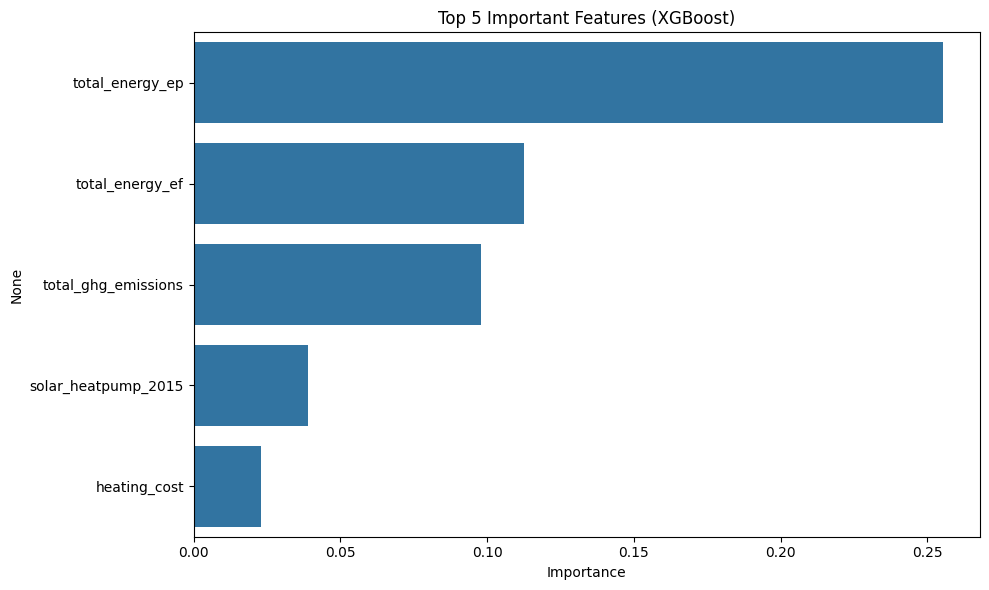

<Figure size 800x600 with 0 Axes>

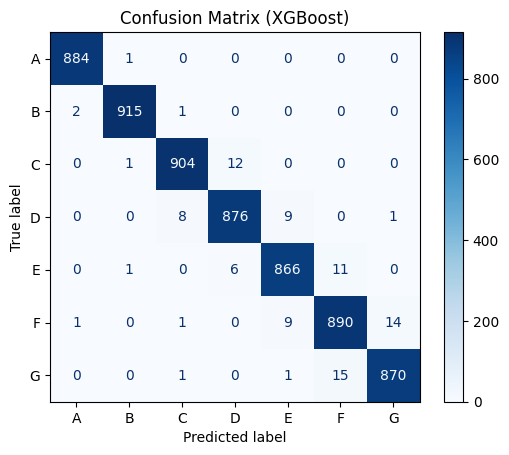

📊 Classification report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       885
           B       1.00      1.00      1.00       918
           C       0.99      0.99      0.99       917
           D       0.98      0.98      0.98       894
           E       0.98      0.98      0.98       884
           F       0.97      0.97      0.97       915
           G       0.98      0.98      0.98       887

    accuracy                           0.98      6300
   macro avg       0.98      0.98      0.98      6300
weighted avg       0.98      0.98      0.98      6300

✅ Test Accuracy (XGBoost): 0.98
🎯 Accuracy ±1 class (tolerance) : 99.90%
🔮 Prediction on user data : A


In [97]:
prediction, acc = train_predict_from_user_input_xgboost(df_reduced, user_data )

In [37]:
len(user_data)

56

# BENCHMARK